## Importing Dependencies




In [ ]:
!pip install opencv-python-headless
!pip install tensorflow
!pip install opendatasets
import random
import glob as glob_mod
import tensorflow as tf
import os
import cv2
from scipy.special import gamma
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import uuid
import gc
import PIL
from tqdm import tqdm
import keras
from keras.optimizers import *
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import *
from keras.layers import Dense, Dropout, Input
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.metrics import *
from sklearn.utils import shuffle
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 76.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 120.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.1 MB/s eta 0:00:00


## Uploading Files to Google Colab




In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sorenairani","key":"334980dcaa8a5038c4058a7aeabc3ada"}'}

In [ ]:
!ls
!mkdir -p ~/.kaggle
!cp "kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

kaggle.json  sample_data


## Downloading Dataset from Kaggle


In [ ]:
!kaggle datasets download -d awsaf49/cbis-ddsm-breast-cancer-image-dataset

Dataset URL: https://www.kaggle.com/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset
License(s): CC-BY-SA-3.0


## Extracting CBIS-DDSM Dataset



In [ ]:
import zipfile
import os
extract_path = "cbis_ddsm_dataset"
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile("cbis-ddsm-breast-cancer-image-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("files extracted succesfully")

files extracted succesfully


## Exploring Dataset Directory Structure




In [ ]:
dataset_root = "cbis_ddsm_dataset"
for entry in os.listdir(dataset_root):
    entry_path = os.path.join(dataset_root, entry)
    if os.path.isdir(entry_path):
        if entry == 'jpeg':
            continue
        else:
            for subfile in os.listdir(entry_path):
                print(subfile)
    else:
        print(entry)

dicom_info.csv
mass_case_description_test_set.csv
mass_case_description_train_set.csv
meta.csv
calc_case_description_train_set.csv
calc_case_description_test_set.csv


## Loading DICOM Metadata

In [ ]:
dicom_df = pd.read_csv("cbis_ddsm_dataset/csv/dicom_info.csv")

In [ ]:
dicom_df.SeriesDescription.unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

In [ ]:
dicom_df.SeriesDescription.value_counts()

SeriesDescription
cropped images           3567
ROI mask images          3247
full mammogram images    2857
Name: count, dtype: int64

# Extract and View Cropped Image Paths

In [ ]:
cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

#Extract and View Full Mammogram Image Paths

In [ ]:
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
full_mammogram.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

#Extract and View ROI Mask Image Paths

In [ ]:
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path
roi_mask.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [ ]:
del dicom_df;    gc.collect()

4

# Adjust File Paths Without Regular Expressions

In [ ]:
def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

# Display Sample Images in Grayscale

In [ ]:
def plot_smaples(sample, row=15, col=15):
    plt.figure(figsize=(row, col))
    for i, file in enumerate(sample[0:5]):
        cropped_images_show = PIL.Image.open(file)
        gray_img= cropped_images_show.convert("L")
        plt.subplot(1,5,i+1)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
    plt.show()

In [ ]:
import os
correct_dir = "cbis_ddsm_dataset/jpeg"
print(os.listdir(correct_dir))

['1.3.6.1.4.1.9590.100.1.2.406519401712404452627759486903243942246', '1.3.6.1.4.1.9590.100.1.2.375319587411015946201453923033781478743', '1.3.6.1.4.1.9590.100.1.2.343599979312034701930436051711071015260', '1.3.6.1.4.1.9590.100.1.2.366216590611306753640326747403142086070', '1.3.6.1.4.1.9590.100.1.2.823895812753986636179936144151938229', '1.3.6.1.4.1.9590.100.1.2.61036743311125583313047274280567048361', '1.3.6.1.4.1.9590.100.1.2.77212619711975684525779833721441146672', '1.3.6.1.4.1.9590.100.1.2.379243319611554381840264920782372740103', '1.3.6.1.4.1.9590.100.1.2.358428832311559154924514548952143981677', '1.3.6.1.4.1.9590.100.1.2.57064283312781860216260996342863969758', '1.3.6.1.4.1.9590.100.1.2.326711620811888171315511763670145940189', '1.3.6.1.4.1.9590.100.1.2.16103292810019418334080239733466318295', '1.3.6.1.4.1.9590.100.1.2.168513812311307055427394175041471803029', '1.3.6.1.4.1.9590.100.1.2.407575669712307303332782404013653965900', '1.3.6.1.4.1.9590.100.1.2.8147101131265012163165024140

# Adjust Image Paths to Absolute Locations

In [ ]:
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0])

Cropped Images paths:
cbis_ddsm_dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg


# Visualize First 5 Cropped Images

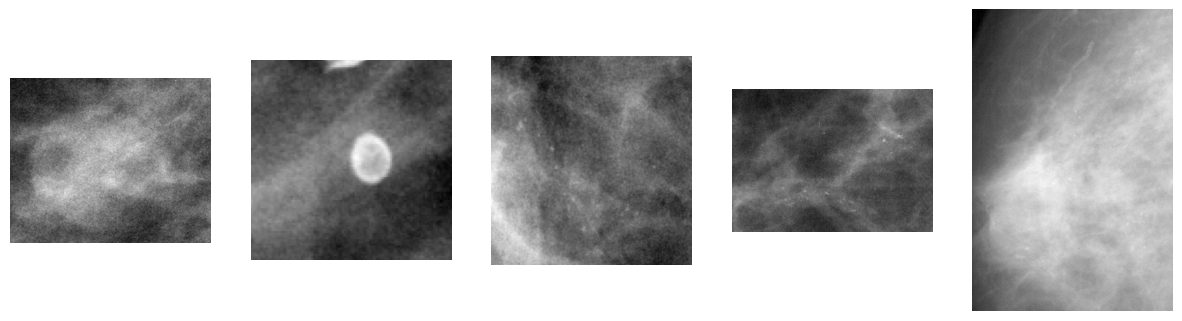

In [ ]:
plot_smaples(cropped_images, 15, 15)

# Adjust and Display Full Mammogram Images

In [ ]:
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0])


Full mammo Images paths:
cbis_ddsm_dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg


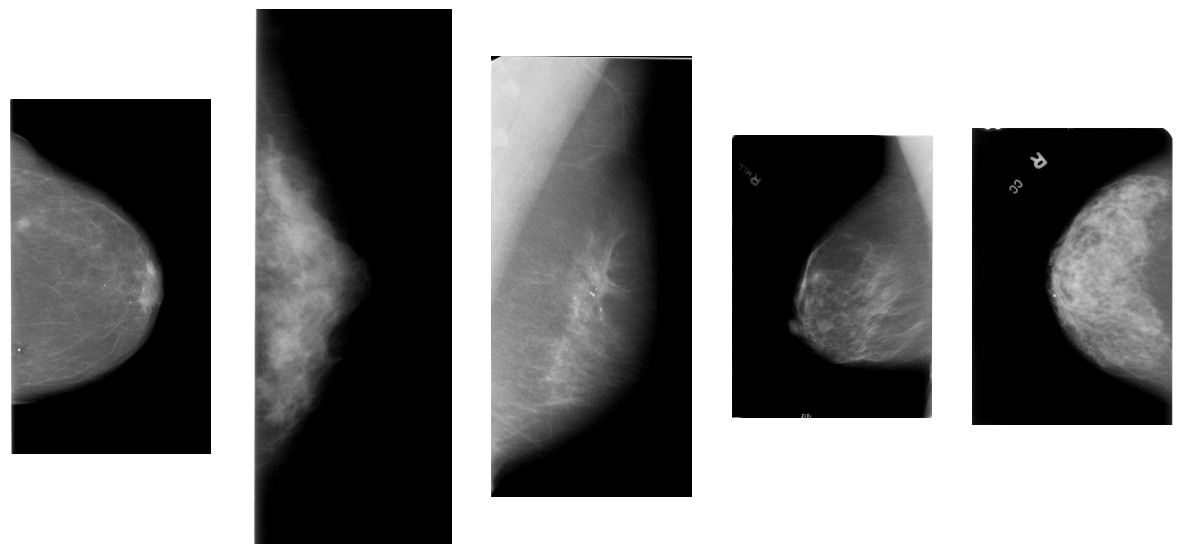

In [ ]:
plot_smaples(full_mammogram)

# Adjust and Display ROI Mask Images

In [ ]:
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0])


ROI Mask Images paths:
cbis_ddsm_dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


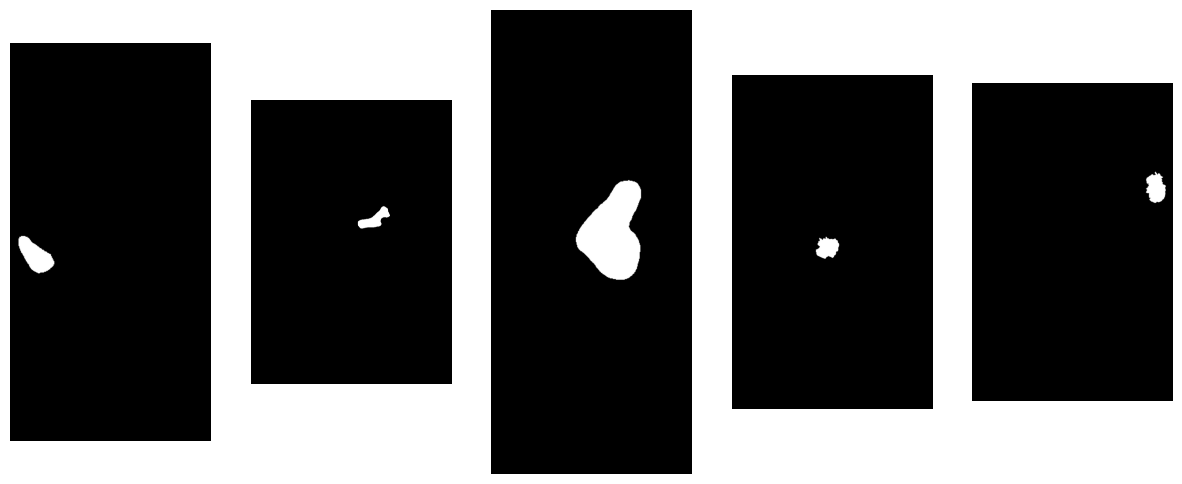

In [ ]:
plot_smaples(roi_mask)

### Function: `get_image_file_name`

In [ ]:
def get_image_file_name(data, new_dict):
    for dicom in data:
        parts = dicom.split('/')
        if len(parts) >= 3:
            key = parts[2]
            new_dict[key] = dicom
        else:
            print(f" short and invalid path {dicom}")
    print(f"valid path {len(new_dict)}")

### Extract Unique Keys for Multiple Image Categories

In [ ]:
cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()
get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)

valid path 3567
valid path 2857
valid path 3247


In [ ]:
next(iter((cropped_images.items())))

(0,
 'cbis_ddsm_dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg')

In [ ]:
next(iter((cropped_images_dict.items())))
print()
print(len(cropped_images_dict.keys()))


3567


In [ ]:
next(iter((full_mammo_dict.items())))
print()
print(len(full_mammo_dict.keys()))


2857


In [ ]:
next(iter((roi_img_dict.items())))
print()
print(len(roi_img_dict.keys()))


3247


### Delete Variables and Perform Garbage Collection

In [ ]:
del cropped_images, full_mammogram, roi_mask;    gc.collect()

21769

### Update Image Paths in DataFrame

In [ ]:
def fix_image_path(data):
    for indx, image in enumerate(data.values):
        img_name = image[11].split('/')[2]
        if img_name in full_mammo_dict:
            data.iloc[indx, 11] = full_mammo_dict[img_name]
        else:
            data.iloc[indx, 11] = None
        img_name = image[12].split('/')[2]
        if img_name in cropped_images_dict:
            data.iloc[indx, 12] = cropped_images_dict[img_name]
        else:
            data.iloc[indx, 11] = None
        img_name = image[13].split('/')[2]
        if img_name in roi_img_dict:
            data.iloc[indx, 13] = roi_img_dict[img_name]
        else:
            data.iloc[indx, 13] = None

### Load CSV Files into DataFrames

In [ ]:
mass_train = pd.read_csv("cbis_ddsm_dataset/csv/mass_case_description_train_set.csv")
mass_test  = pd.read_csv("cbis_ddsm_dataset/csv/mass_case_description_test_set.csv")

### DataFrame Update and Renaming Columns



In [ ]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
mass_train.head(5)

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality_type                          mass_shape   mass_margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image_file_path  \
0  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...   
1  Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...   
2  Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...   
3  Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...   
4  Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...   

                             cropped_image_file_path  \
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...   
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...   
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....   

                                  ROI_mask_file_path  
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...  
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...  
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....

### DataFrame Update for Mass Test Set

In [ ]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})
mass_test.head()

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00016               4                 LEFT         CC               1   
1    P_00016               4                 LEFT        MLO               1   
2    P_00017               2                 LEFT         CC               1   
3    P_00017               2                 LEFT        MLO               1   
4    P_00032               3                RIGHT         CC               1   

  abnormality_type mass_shape   mass_margins  assessment  pathology  subtlety  \
0             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
1             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
2             mass      ROUND  CIRCUMSCRIBED           4  MALIGNANT         4   
3             mass      ROUND    ILL_DEFINED           4  MALIGNANT         4   
4             mass      ROUND       OBSCURED           0     BENIGN         2   

                                     image_file_path  \
0  Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...   
1  Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...   
2  Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...   
3  Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...   
4  Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...   

                             cropped_image_file_path  \
0  Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1  Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....   
2  Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
3  Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....   
4  Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....   

                                  ROI_mask_file_path  
0  Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
1  Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....  
2  Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
3  Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....  
4  Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....

In [ ]:
fix_image_path(mass_train)

In [ ]:
mass_train.pathology.unique()

array(['MALIGNANT', 'BENIGN', 'BENIGN_WITHOUT_CALLBACK'], dtype=object)

In [ ]:
mass_test.head()

patient_id  breast_density left_or_right_breast image_view  abnormality_id  \
0    P_00016               4                 LEFT         CC               1   
1    P_00016               4                 LEFT        MLO               1   
2    P_00017               2                 LEFT         CC               1   
3    P_00017               2                 LEFT        MLO               1   
4    P_00032               3                RIGHT         CC               1   

  abnormality_type mass_shape   mass_margins  assessment  pathology  subtlety  \
0             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
1             mass  IRREGULAR     SPICULATED           5  MALIGNANT         5   
2             mass      ROUND  CIRCUMSCRIBED           4  MALIGNANT         4   
3             mass      ROUND    ILL_DEFINED           4  MALIGNANT         4   
4             mass      ROUND       OBSCURED           0     BENIGN         2   

                                     image_file_path  \
0  Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...   
1  Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...   
2  Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...   
3  Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...   
4  Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...   

                             cropped_image_file_path  \
0  Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1  Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....   
2  Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
3  Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....   
4  Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....   

                                  ROI_mask_file_path  
0  Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
1  Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....  
2  Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
3  Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....  
4  Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....

In [ ]:
mass_train.iloc[:, 11].head()

0    cbis_ddsm_dataset/jpeg/1.3.6.1.4.1.9590.100.1....
1    cbis_ddsm_dataset/jpeg/1.3.6.1.4.1.9590.100.1....
2    cbis_ddsm_dataset/jpeg/1.3.6.1.4.1.9590.100.1....
3    cbis_ddsm_dataset/jpeg/1.3.6.1.4.1.9590.100.1....
4    cbis_ddsm_dataset/jpeg/1.3.6.1.4.1.9590.100.1....
Name: image_file_path, dtype: object

In [ ]:
fix_image_path(mass_test)

### Displaying the Shape of the DataFrames

In [ ]:
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [ ]:
calc_train = pd.read_csv("cbis_ddsm_dataset/csv/calc_case_description_train_set.csv")
calc_test  = pd.read_csv("cbis_ddsm_dataset/csv/calc_case_description_test_set.csv")

In [ ]:
calc_train.iloc[:,11].head()

0    Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...
1    Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...
2    Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...
3    Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...
4    Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...
Name: image file path, dtype: object

### DataFrame Update for Calc Train Set

In [ ]:
calc_train = calc_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})
calc_train.head()

patient_id  breast density left_or_right_breast image_view  abnormality_id  \
0    P_00005               3                RIGHT         CC               1   
1    P_00005               3                RIGHT        MLO               1   
2    P_00007               4                 LEFT         CC               1   
3    P_00007               4                 LEFT        MLO               1   
4    P_00008               1                 LEFT         CC               1   

  abnormality_type    calc type calc distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1                MALIGNANT         3   
2                   BENIGN         4   
3                   BENIGN         4   
4  BENIGN_WITHOUT_CALLBACK         3   

                                     image_file_path  \
0  Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...   
1  Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...   
2  Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...   
3  Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...   
4  Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   

                             cropped_image_file_path  \
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...   
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....   
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...   

                                  ROI_mask_file_path  
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...  
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....  
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...

In [ ]:
fix_image_path(calc_train)

In [ ]:
calc_test.head()

patient_id  breast density left or right breast image view  abnormality id  \
0    P_00038               2                 LEFT         CC               1   
1    P_00038               2                 LEFT        MLO               1   
2    P_00038               2                RIGHT         CC               1   
3    P_00038               2                RIGHT         CC               2   
4    P_00038               2                RIGHT        MLO               1   

  abnormality type             calc type calc distribution  assessment  \
0    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
1    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
2    calcification              VASCULAR               NaN           2   
3    calcification              VASCULAR               NaN           2   
4    calcification              VASCULAR               NaN           2   

                 pathology  subtlety  \
0                   BENIGN         2   
1                   BENIGN         2   
2  BENIGN_WITHOUT_CALLBACK         5   
3  BENIGN_WITHOUT_CALLBACK         5   
4  BENIGN_WITHOUT_CALLBACK         5   

                                     image file path  \
0  Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...   
1  Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...   
2  Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...   
3  Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...   
4  Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...   

                             cropped image file path  \
0  Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1  Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....   
2  Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....   
3  Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....   
4  Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...   

                                  ROI mask file path  
0  Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
1  Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....  
2  Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....  
3  Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....  
4  Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...

In [ ]:
calc_test.iloc[:,11].head()

0    Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...
1    Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...
2    Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...
3    Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...
4    Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...
Name: image file path, dtype: object

### DataFrame Update for Calc Test Set

In [ ]:
calc_test = calc_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})
calc_test.head()


patient_id  breast density left_or_right_breast image_view  abnormality_id  \
0    P_00038               2                 LEFT         CC               1   
1    P_00038               2                 LEFT        MLO               1   
2    P_00038               2                RIGHT         CC               1   
3    P_00038               2                RIGHT         CC               2   
4    P_00038               2                RIGHT        MLO               1   

  abnormality_type             calc type calc distribution  assessment  \
0    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
1    calcification  PUNCTATE-PLEOMORPHIC         CLUSTERED           4   
2    calcification              VASCULAR               NaN           2   
3    calcification              VASCULAR               NaN           2   
4    calcification              VASCULAR               NaN           2   

                 pathology  subtlety  \
0                   BENIGN         2   
1                   BENIGN         2   
2  BENIGN_WITHOUT_CALLBACK         5   
3  BENIGN_WITHOUT_CALLBACK         5   
4  BENIGN_WITHOUT_CALLBACK         5   

                                     image_file_path  \
0  Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...   
1  Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...   
2  Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...   
3  Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...   
4  Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...   

                             cropped_image_file_path  \
0  Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...   
1  Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....   
2  Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....   
3  Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....   
4  Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...   

                                  ROI_mask_file_path  
0  Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...  
1  Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....  
2  Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....  
3  Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....  
4  Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...

In [ ]:
fix_image_path(calc_test)

### Print Shape of Calc Train and Calc Test DataFrames

In [ ]:
print(f'Shape of mass_train: {calc_train.shape}')
print(f'Shape of mass_test: {calc_test.shape}')

Shape of mass_train: (1546, 14)
Shape of mass_test: (326, 14)


### Show Images Function

In [ ]:
def display_images(dataset, column, number):
    fig, axes = plt.subplots(1, number, figsize=(15, 5))
    for index, (i, row) in enumerate(dataset.head(number).iterrows()):
        image_path = row[column]
        if image_path is None or not os.path.exists(image_path):
            continue
        image = cv2.imread(image_path)
        if image is None:
            continue
        if len(image.shape) == 3 and image.shape[2] == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = axes[index]
        ax.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
        print(np.array(image).shape)
    plt.tight_layout()
    plt.show()

Full Mammograms:

(4808, 3024, 3)
(4800, 2656, 3)
(5491, 2986, 3)
(5491, 3046, 3)
(5491, 2911, 3)


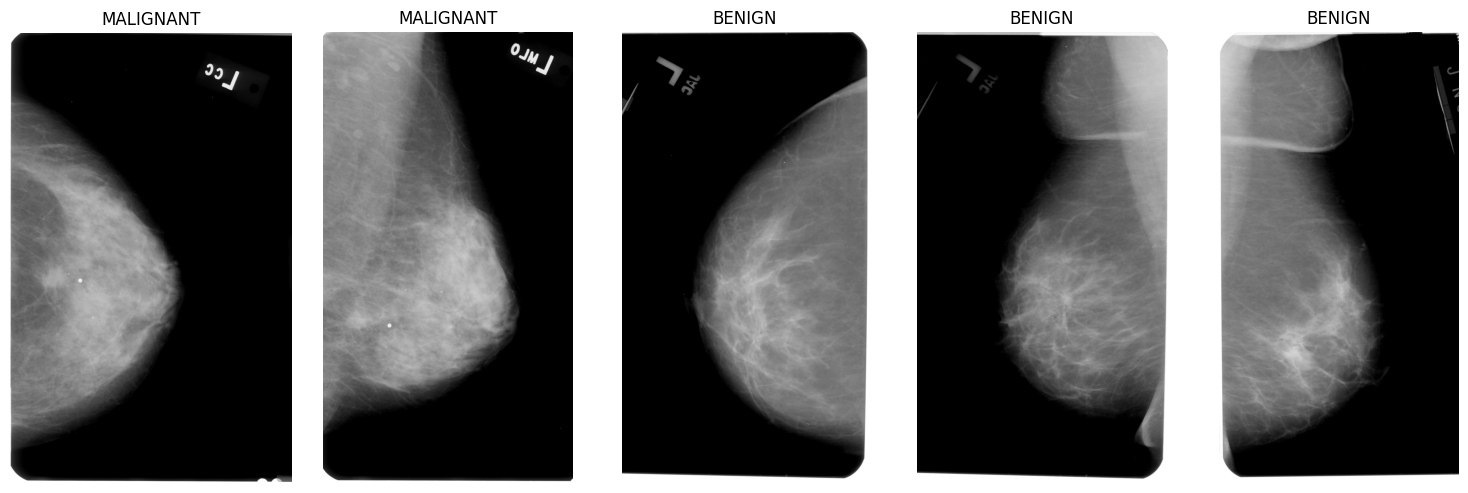

Cropped Mammograms:

(515, 431, 3)
(292, 256, 3)
(466, 423, 3)
(427, 422, 3)
(399, 465, 3)


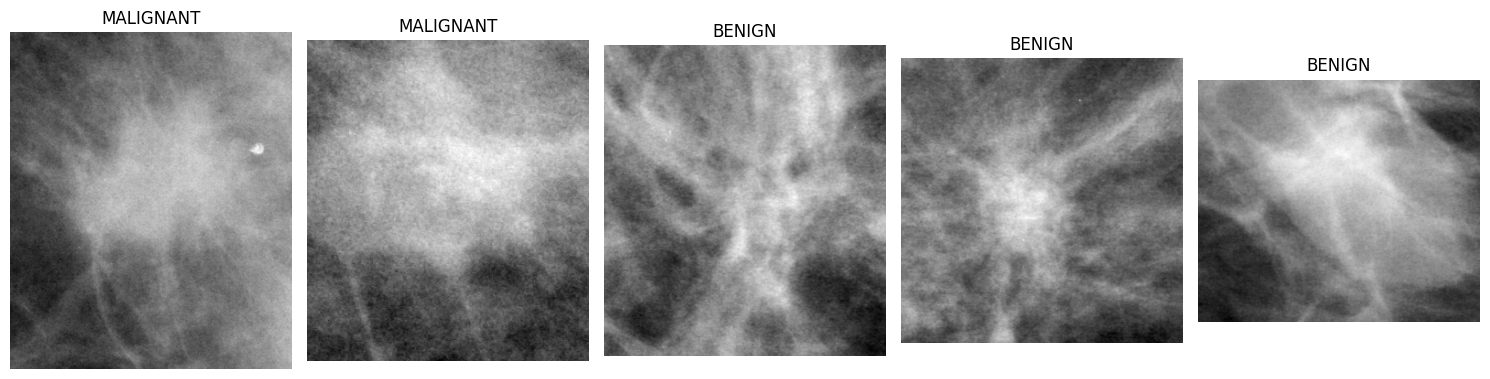

ROI_mask:

(4808, 3024, 3)
(4800, 2656, 3)
(5491, 2986, 3)
(5491, 3046, 3)
(5491, 2911, 3)


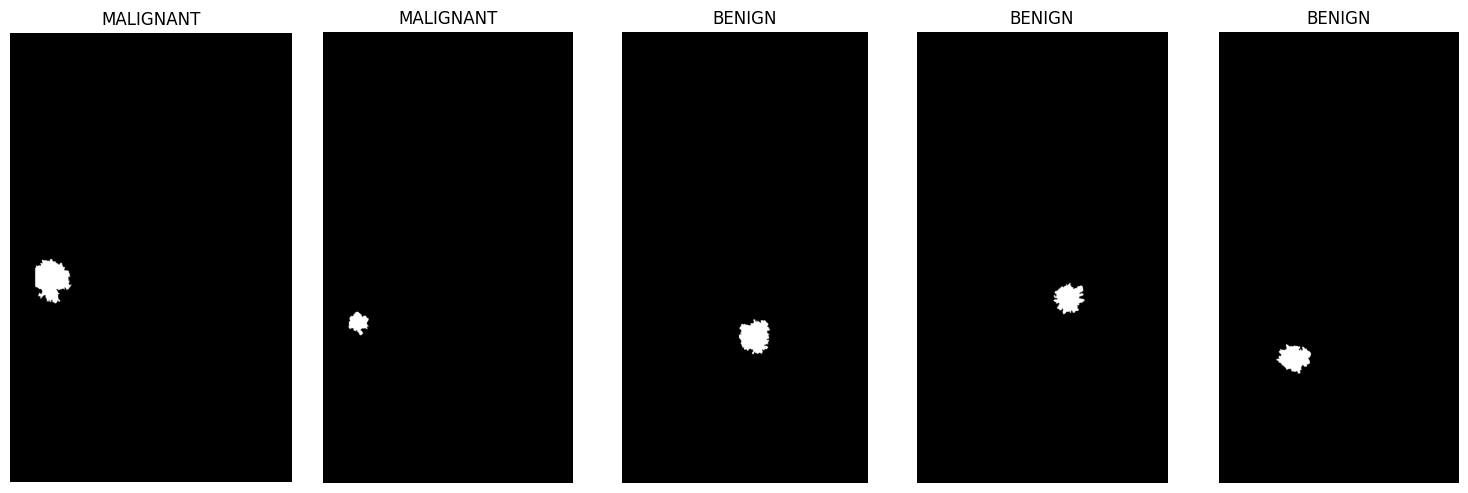

In [ ]:
print('Full Mammograms:\n')
display_images(mass_train, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(mass_train, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(mass_train, 'ROI_mask_file_path', 5)

Full Mammograms:

(4006, 1846, 3)
(5491, 2011, 3)
(5904, 3200, 3)
(5952, 3352, 3)
(5116, 2641, 3)


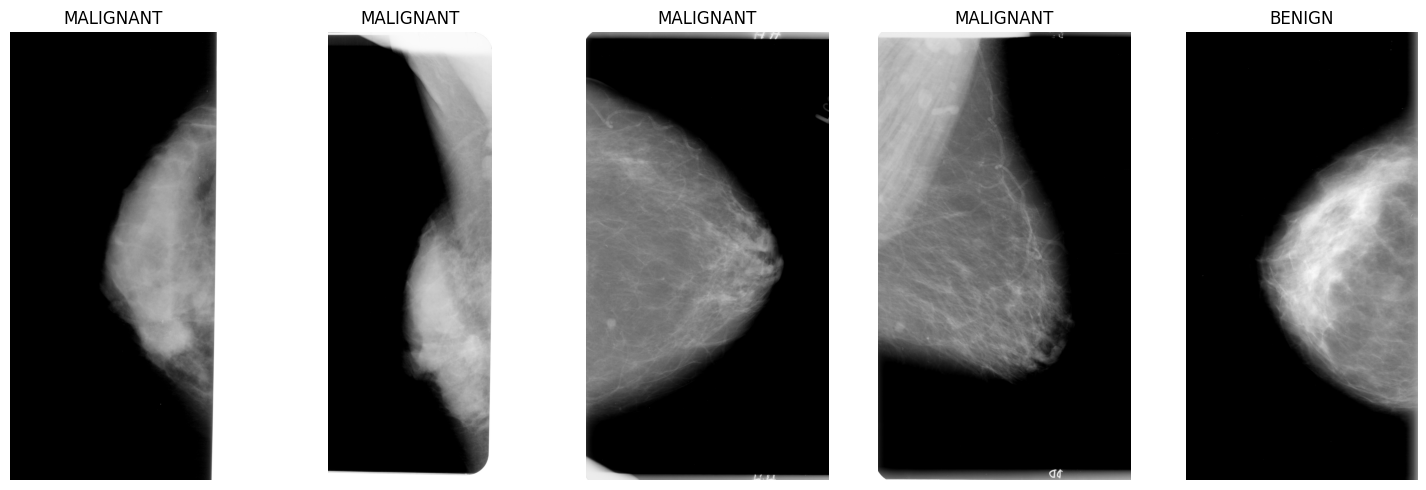

Cropped Mammograms:

(384, 385, 3)
(369, 328, 3)
(214, 195, 3)
(220, 225, 3)
(405, 376, 3)


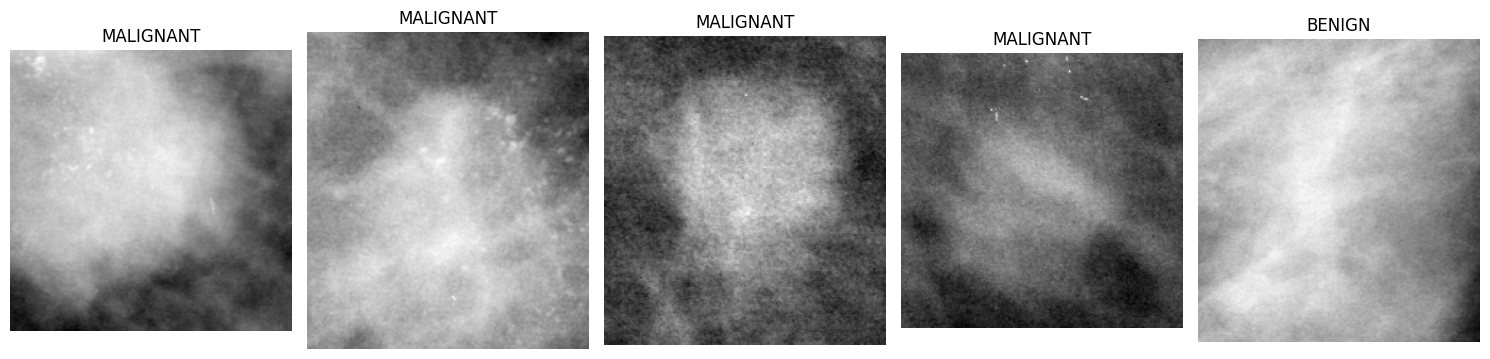

ROI_mask:

(4006, 1846, 3)
(5491, 2011, 3)
(5904, 3200, 3)
(5952, 3352, 3)
(5116, 2641, 3)


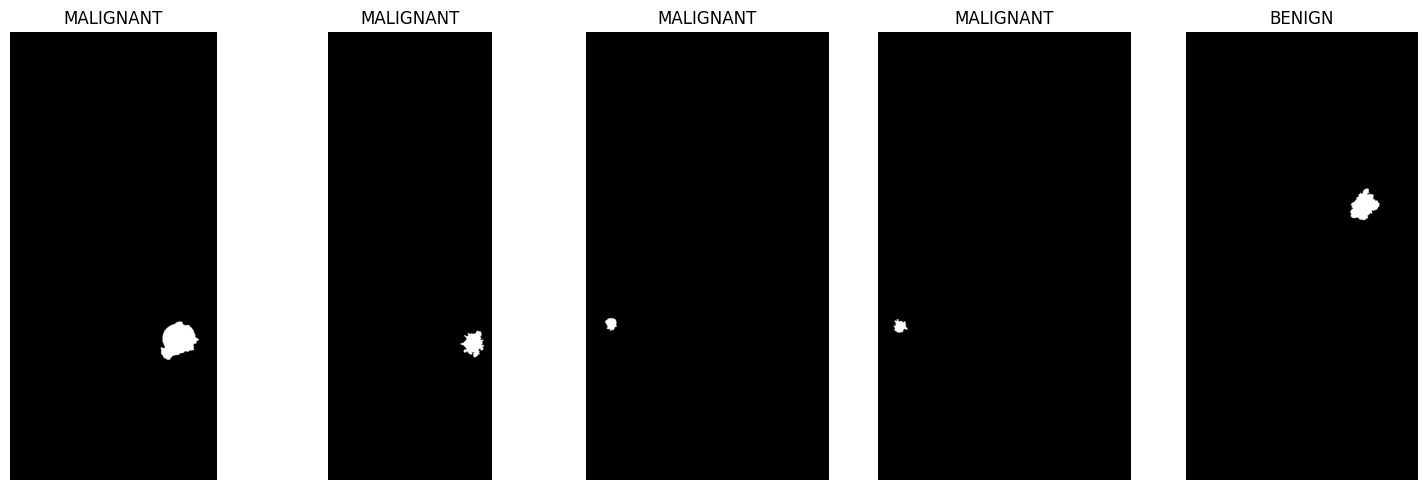

In [ ]:
print('Full Mammograms:\n')
display_images(mass_test, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(mass_test, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(mass_test, 'ROI_mask_file_path', 5)

Full Mammograms:

(5056, 2761, 3)
(5386, 2836, 3)
(5356, 2986, 3)
(5491, 3166, 3)
(4568, 3064, 3)


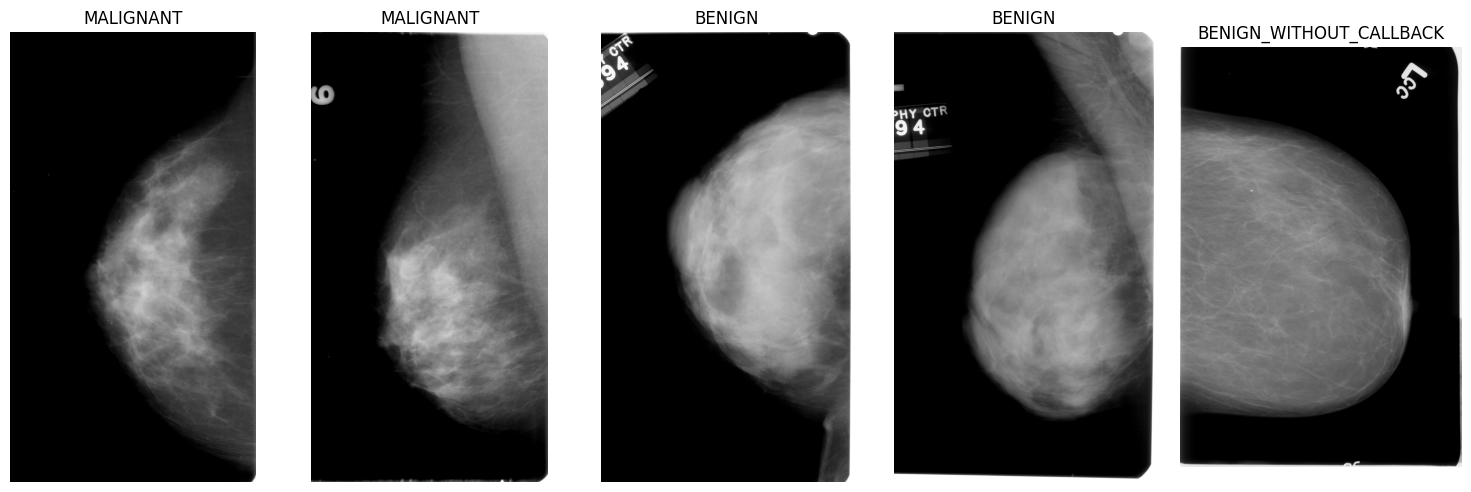

Cropped Mammograms:

(589, 677, 3)
(549, 681, 3)
(681, 577, 3)
(689, 761, 3)
(161, 177, 3)


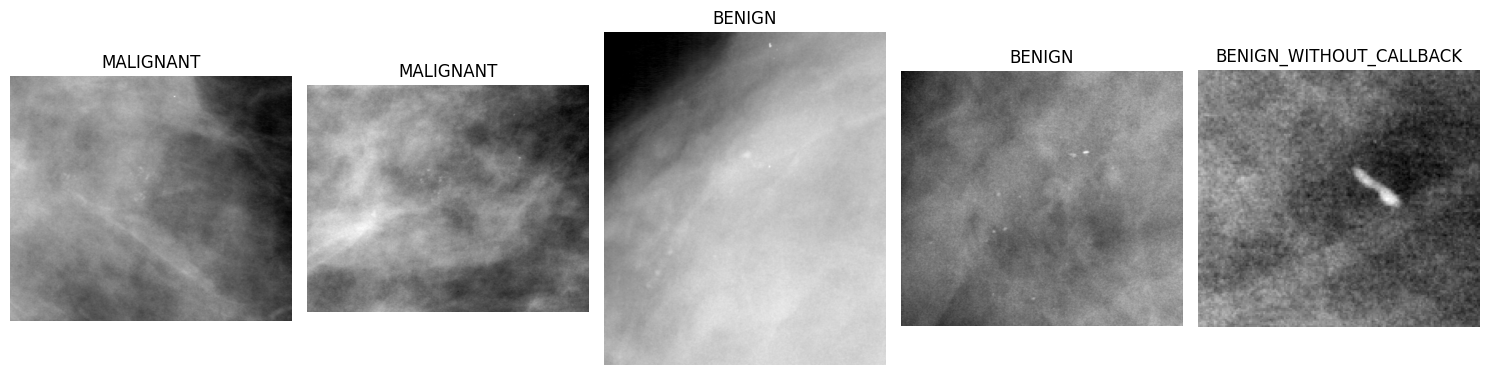

ROI_mask:

(5056, 2761, 3)
(5386, 2836, 3)
(5356, 2986, 3)
(5491, 3166, 3)
(4568, 3064, 3)


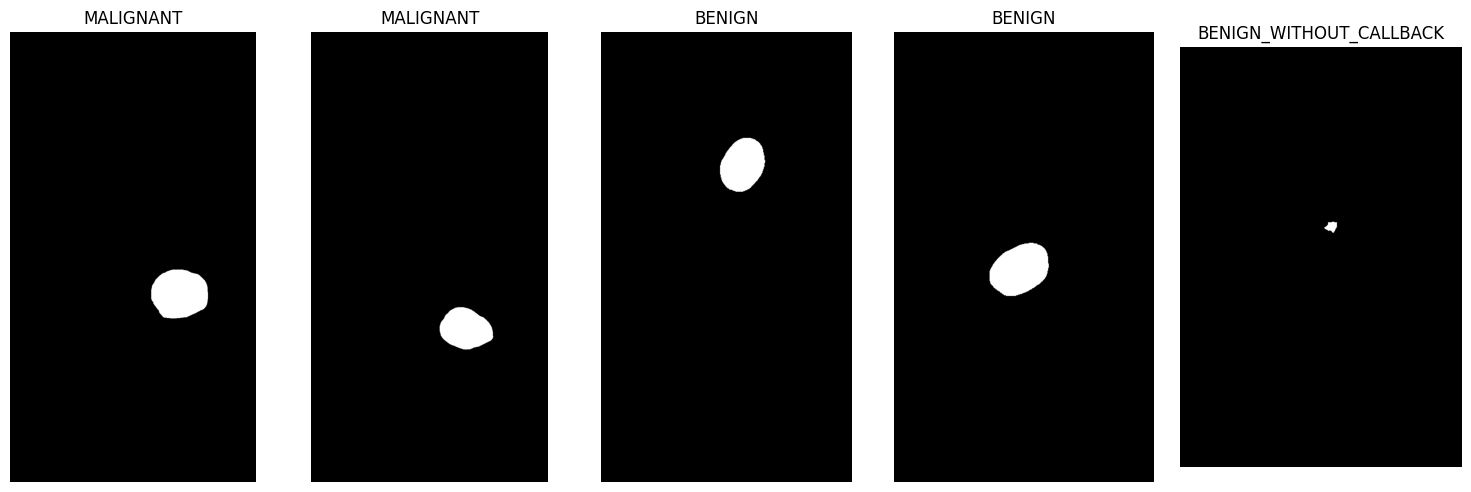

In [ ]:
print('Full Mammograms:\n')
display_images(calc_train, 'image_file_path', 5)
print('Cropped Mammograms:\n')
display_images(calc_train, 'cropped_image_file_path', 5)
print('ROI_mask:\n')
display_images(calc_train, 'ROI_mask_file_path', 5)

# Create full dataset

In [ ]:
# full_dataset = pd.concat([mass_train, mass_test, calc_train, calc_test], axis=0)
# full_dataset = pd.concat([mass_train, mass_test], axis=0)
full_dataset = pd.concat([calc_train, calc_test], axis=0)

In [ ]:
del mass_train, mass_test, calc_train, calc_test;    gc.collect()

97677

### Class Mapper Dictionary

In [ ]:
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

### Target Image Size Definition

In [ ]:
target_size = (224, 224, 3)

### Processing and Extracting Image Paths and Labels

In [ ]:
full_dataset['labels'] = full_dataset['pathology'].replace(class_mapper).infer_objects(copy=False)
full_images = np.array(full_dataset[full_dataset["image_file_path"].notna()]["image_file_path"].tolist())
full_labels = np.array(full_dataset[full_dataset["image_file_path"].notna()]["labels"].tolist())

<ipython-input-57-aa7b7930493b>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_dataset['labels'] = full_dataset['pathology'].replace(class_mapper).infer_objects(copy=False)


In [ ]:
len(full_images)

1588

### Counting and Displaying Label Distribution

In [ ]:
full_labels_series = pd.Series(full_labels)
label_counts = full_labels_series.value_counts()
benign_count = label_counts.get(0, 0)
malignant_count = label_counts.get(1, 0)
print(f"Benign images: {benign_count}")
print(f"Malignant images: {malignant_count}")

Benign images: 1018
Malignant images: 570


### Determining the Number of Unique Classes

In [ ]:
num_classes = len(full_dataset['labels'].unique())
num_classes

2

In [ ]:
class_names = ['Benign', 'Malignant']

In [ ]:
new_dir = "/kaggle/working/merged_images"
if not os.path.exists(new_dir):
    os.makedirs(new_dir)
    print(f" Created directory: {new_dir}")
else:
    print(f" Directory already exists: {new_dir}")

 Created directory: /kaggle/working/merged_images


### Removing Files and Directories

In [ ]:
dir_path = '/kaggle/working'
for filename in os.listdir(dir_path):
    file_path = os.path.join(dir_path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')
print("All files and subdirectories in '/kaggle/working' have been removed.")

All files and subdirectories in '/kaggle/working' have been removed.


### Counting Images in Each Class

In [ ]:
def images_count():
    zero_class_count = len(os.listdir("/kaggle/working/merged_images/0"))
    one_class_count  = len(os.listdir("/kaggle/working/merged_images/1"))
    print(f"Number of images in class 0: {zero_class_count}")
    print(f"Number of images in class 1: {one_class_count}")

### Data Augmentation Function

In [ ]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image
def resize_image(image_tensor):
    return tf.image.resize(image_tensor, [224, 224])
def copy_images_with_unique_filenames(images, labels, source, destination, target_count=None):
    benign_images = 0
    malignant_images = 0
    skipped_images = []
    category_dest_dir_zero = os.path.join(destination, '0')
    os.makedirs(category_dest_dir_zero, exist_ok=True)
    category_dest_dir_one = os.path.join(destination, '1')
    os.makedirs(category_dest_dir_one, exist_ok=True)
    benign_images_list = []
    malignant_images_list = []
    for i, (image, label) in enumerate(zip(images, labels)):
#         img_name = data_frame.REFNUM[i]
#         abs_path = os.path.join(source, img_name + '.pgm')
        if os.path.exists(image):
            try:
                filename = os.path.basename(image)
                unique_filename = f"{uuid.uuid4().hex}_{filename}"
                with Image.open(image) as img:
                    img = img.convert('RGB')
                    img_tensor = tf.convert_to_tensor(img)
                    resized_img_tensor = resize_image(img_tensor)
                    augmented_image_tensor = augment_image(resized_img_tensor)
                    augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_tensor)
                    if label == 0:
                        benign_images_list.append(unique_filename)
                        dest_path = os.path.join(category_dest_dir_zero, unique_filename)
#                         augmented_image.save(dest_path, 'JPEG')
                        augmented_image.save(dest_path, 'JPEG')
                        benign_images += 1
                    elif label == 1:
                        malignant_images_list.append(unique_filename)
                        dest_path = os.path.join(category_dest_dir_one, unique_filename)
#                         augmented_image.save(dest_path, 'JPEG')
                        augmented_image.save(dest_path, 'JPEG')
                        malignant_images += 1
#                 del img, img_tensor, resized_img_tensor, augmented_image_tensor, augmented_image
#                 gc.collect()
            except Exception as e:
                print(f"Error copying image {image}: {e}")
                skipped_images.append(image)
        else:
            print(f"Image not found: {image}")
            skipped_images.append(image)
    benign_count = len(benign_images_list)
    malignant_count = len(malignant_images_list)
    if benign_count < malignant_count:
#         augment_and_save_images(benign_images_list, category_dest_dir_zero, target_count - benign_count)
        augment_and_save_images(benign_images_list, category_dest_dir_zero, malignant_count - benign_count)
    elif malignant_count < benign_count:
        augment_and_save_images(malignant_images_list, category_dest_dir_one, benign_count - malignant_count)
    print("data balancing")
    images_count()
    augment_and_save_images(benign_images_list, category_dest_dir_zero, target_count)
    augment_and_save_images(malignant_images_list, category_dest_dir_one, target_count)
    print("data augmentation")
    images_count()
    if skipped_images:
        print("Skipped images:")
        for img in skipped_images:
            print(img)
    del skipped_images, benign_images_list, malignant_images_list
    gc.collect()
def augment_and_save_images(images_list, destination_dir, num_augments):
    for i in range(num_augments):
        img_name = random.choice(images_list)
        abs_path = os.path.join(destination_dir, img_name)
        try:
            with Image.open(abs_path) as img:
                img = img.convert('RGB')
                img_tensor = tf.convert_to_tensor(img)
#                 resized_img_tensor = resize_image(img_tensor)
                augmented_image_tensor = augment_image(img_tensor)
                augmented_image = tf.keras.preprocessing.image.array_to_img(augmented_image_tensor)
                img_name_without_ext = os.path.splitext(img_name)[0]
                augmented_image.save(os.path.join(destination_dir, img_name_without_ext + f'_aug{i}.jpg'), 'JPEG')
#                 del img, img_tensor, augmented_image_tensor, augmented_image, img_name_without_ext
#                 gc.collect()
        except Exception as e:
            print(f"Error augmenting image {abs_path}: {e}")
source_dir = "/kaggle/working/mias-mammography/all-mias"
destination_dir = "/kaggle/working/merged_images"
target_count = int((len(full_labels) * 5) // 2)
copy_images_with_unique_filenames(full_images, full_labels, source_dir, destination_dir, target_count)

data balancing
Number of images in class 0: 1018
Number of images in class 1: 1018
data augmentation
Number of images in class 0: 4988
Number of images in class 1: 4988


In [ ]:
import os
import uuid
from PIL import Image
import tensorflow as tf
import gc
def resize_image(image_tensor):
    return tf.image.resize(image_tensor, [224, 224])
def copy_images_with_unique_filenames(images, labels, source, destination):
    benign_images = 0
    malignant_images = 0
    skipped_images = []
    category_dest_dir_zero = os.path.join(destination, '0')
    os.makedirs(category_dest_dir_zero, exist_ok=True)
    category_dest_dir_one = os.path.join(destination, '1')
    os.makedirs(category_dest_dir_one, exist_ok=True)
    for i, (image, label) in enumerate(zip(images, labels)):
        if os.path.exists(image):
            try:
                filename = os.path.basename(image)
                unique_filename = f"{uuid.uuid4().hex}_{filename}"
                with Image.open(image) as img:
                    img = img.convert('RGB')
                    img_tensor = tf.convert_to_tensor(img)
                    resized_img_tensor = resize_image(img_tensor)
                    resized_image = tf.keras.preprocessing.image.array_to_img(resized_img_tensor)
                    if label == 0:
                        dest_path = os.path.join(category_dest_dir_zero, unique_filename)
                        resized_image.save(dest_path, 'JPEG')
                        benign_images += 1
                    elif label == 1:
                        dest_path = os.path.join(category_dest_dir_one, unique_filename)
                        resized_image.save(dest_path, 'JPEG')
                        malignant_images += 1
            except Exception as e:
                print(f"Error copying image {image}: {e}")
                skipped_images.append(image)
        else:
            print(f"Image not found: {image}")
            skipped_images.append(image)
    print(f"\nCopying complete.")
    print(f"Benign images copied (label 0): {benign_images}")
    print(f"Malignant images copied (label 1): {malignant_images}")
    print(f"Total skipped images: {len(skipped_images)}")
    if skipped_images:
        print("Skipped images:")
        for img in skipped_images:
            print(img)
    del skipped_images
    gc.collect()
source_dir = "/kaggle/working/mias-mammography/all-mias"
destination_dir = "/kaggle/working/merged_images"
copy_images_with_unique_filenames(full_images, full_labels, source_dir, destination_dir)


Copying complete.
Benign images copied (label 0): 1018
Malignant images copied (label 1): 570
Total skipped images: 0


In [ ]:
target_count

3970

In [ ]:
images_count()

Number of images in class 0: 4988
Number of images in class 1: 4988


### TensorFlow Data Preprocessing and Augmentation

In [ ]:
import tensorflow as tf
data_dir = '/kaggle/working/merged_images'
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    seed=30,
    shuffle=True,
    batch_size=13
)
total_samples = tf.data.experimental.cardinality(full_dataset).numpy()
train_size = int(0.7 * total_samples)
test_size = total_samples - train_size
train_dataset       = full_dataset.take(train_size)
test_dataset        = full_dataset.skip(train_size)
train_dataset      = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset       = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
print(f"Train samples:      {train_size}     batches(8) ==> {train_size*13}")
print(f"Test samples:       {test_size}      batches(8) ==> {test_size*13}")
del full_dataset, total_samples, train_size, test_size;    gc.collect()

Found 9976 files belonging to 2 classes.
Train samples:      537     batches(8) ==> 6981
Test samples:       231      batches(8) ==> 3003


0

### Custom Model Creation with Transfer Learning

In [ ]:
from tensorflow.keras.applications import (ResNet50,
                                           Xception,
                                           VGG19,
                                           InceptionV3,
                                           DenseNet121,
                                           NASNetMobile,
                                           MobileNetV2,
                                           MobileNet,
                                           EfficientNetV2B0,
                                           EfficientNetV2S,
                                           EfficientNetV2L,
                                           ConvNeXtBase)
def create_model(model_name, trainable_layers, dropout_value, save_weights=False):
    model_dict = {
        "ResNet50":         ResNet50,
        "Xception":         Xception,
        "VGG19":         VGG19,
        "InceptionV3":      InceptionV3,
        "DenseNet121":      DenseNet121,
        "NASNetMobile":     NASNetMobile,
        "MobileNetV2":      MobileNetV2,
        "MobileNet":        MobileNet,
        "EfficientNetV2B0": EfficientNetV2B0,
        "EfficientNetV2S":  EfficientNetV2S,
        "EfficientNetV2L":  EfficientNetV2L,
        "ConvNeXtBase":     ConvNeXtBase,
    }
    if model_name not in model_dict:
        raise ValueError(f"Model {model_name} is not supported.")
    base_model = model_dict[model_name](weights='imagenet' if not save_weights else None,
                                        include_top=False,
                                        input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False
    from_index = int(np.round((len(base_model.layers) - 1) * (1.0 - trainable_layers / 100.0)))
    for layer in base_model.layers[from_index:]:
        layer.trainable = True
#flatten
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout_value)(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    del model_dict, base_model, from_index, x, predictions;    gc.collect()
    return model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
import gc
import numpy as np
def create_model(model_name, trainable_layers, dropout_value, save_weights=False):
    if model_name != "ANN":
        raise ValueError("Only 'ANN' model is supported in this version.")
    inputs = Input(shape=(224, 224, 3))
    x = Flatten()(inputs)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout_value)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_value)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(dropout_value)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(dropout_value)(x)
    predictions = Dense(2, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=predictions)
    del x, predictions
    gc.collect()
    return model

In [ ]:
from multiprocessing import cpu_count
n_cores = cpu_count()
print(f'Number of Logical CPU cores: {n_cores}')

Number of Logical CPU cores: 96


In [ ]:
def make_file():
    os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
    os.makedirs(LOGS_DIR, exist_ok=True)

In [ ]:
from keras import backend as K
def reset_memory():
    K.clear_session()
    gc.collect()

### Defining Project Paths and Image Dimensions

In [ ]:
PROJECT_PATH    = "/kaggle/working/"
CHECKPOINTS_DIR = os.path.join(PROJECT_PATH, "Checkpoints")
LOGS_DIR        = os.path.join(PROJECT_PATH, "Logs")
WIDTH = 162

### Model Training Function

In [ ]:
def run_model(trainable_layers,
              optimizer_class,
              batch_size_value,
              dropout_value,
              model_name=None,
              save=False,
              epochs=5,
              patience=2):
    if model_name is None:
        models = ["ConvNeXtBase"]
        # models = ["EfficientNetV2L"]
        # models = ["ANN"]
    else:
        models = [model_name]
    best_score = float('-inf')
    best_model_info = None
    for model_name in models:
        tf.keras.backend.clear_session();    gc.collect()
        model = create_model(model_name, trainable_layers, dropout_value)
        optimizer_value = optimizer_class()
        model.compile(optimizer=optimizer_value,
                      loss='categorical_crossentropy',
                      metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
        trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
        print('')
        output = (f"Training model: {model_name}   "
                  f"Layers: {len(model.layers)}   "
                  f"Parameters: {model.count_params()}   "
                  f"Trainable parameters: {trainable_params}")
        print(output.center(WIDTH))
        print(f'#%% {"-" * 97} %'.center(WIDTH))
        if save:
            solution = [trainable_layers, optimizer_value.__class__.__name__, batch_size_value, dropout_value]
            keyword = f"{model_name}-" + "-".join([str(el) for el in solution])
            checkpointPath = os.path.join(PROJECT_PATH, "Checkpoints", keyword) + ".weights.h5"
            csvLogPath = os.path.join(PROJECT_PATH, "Logs", keyword) + ".csv"
            make_file()
        callbacks = [
            TerminateOnNaN(),
            EarlyStopping(monitor="accuracy", mode="max", patience=patience)
        ]
        if save:
            callbacks += [
                ModelCheckpoint(checkpointPath,
                                save_best_only=True,
                                save_weights_only=True,
                                monitor="accuracy",
                                mode="max",
                                verbose=0),
                CSVLogger(csvLogPath, append=True)
            ]
        sampled_train_dataset = train_dataset.unbatch().shuffle(1000).take(100).batch(batch_size_value)
        history = model.fit(
            sampled_train_dataset,
            epochs=epochs,
            callbacks=callbacks
        )
        if save:
            return model, history
        score = history.history['accuracy'][-1]
        if score > best_score:
            best_score = score
            best_model_info = {
                'model_name': model_name,
                'trainable_layers': trainable_layers,
                'optimizer': optimizer_value.__class__.__name__,
                'batch_size': batch_size_value,
                'dropout_value': dropout_value
            }
        reset_memory()
        print(f"Model {model_name} cleared from memory".center(WIDTH))
        print()
        return model

### Model Training Invocation

In [ ]:
model, history = run_model(5,
                           Adam,
                           8,
                           0,
                           None,
                           True,
                           10,
                           # save=True,
                           patience=100)


                                Training model: ConvNeXtBase   Layers: 263   Parameters: 88618114   Trainable parameters: 17898498                                
                             #%% ------------------------------------------------------------------------------------------------- %                              
Epoch 1/10
     13/Unknown 620s 45s/step - accuracy: 0.6305 - loss: 1.9970 - precision: 0.6305 - recall: 0.6305

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 627s 46s/step - accuracy: 0.6269 - loss: 1.9856 - precision: 0.6269 - recall: 0.6269
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 609s 46s/step - accuracy: 0.5015 - loss: 1.0241 - precision: 0.5015 - recall: 0.5015
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 628s 47s/step - accuracy: 0.6334 - loss: 0.6775 - precision: 0.6334 - recall: 0.6334
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 624s 48s/step - accuracy: 0.5590 - loss: 0.7519 - precision: 0.5590 - recall: 0.5590
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 655s 46s/step - accuracy: 0.5916 - loss: 0.6574 - precision: 0.5916 - recall: 0.5916
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 612s 47s/step - accuracy: 0.6679 - loss: 0.6166 - precision: 0.6679 - recall: 0.6679
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 655s 49s/step - accuracy: 0.7185 - loss: 0.5823 - precision: 0.7185 - recall: 0.7185
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 615s 47s/step - accuracy: 0.7128 - loss: 0.5704 - precision: 0.7128 - recall: 0.7128
Epoch 9/10
13/13 ━━━━━━━━━━

In [ ]:
model, history = run_model(5,
                           Adam,
                           8,
                           0,
                           None,
                           True,
                           10,
                           # save=True,
                           patience=100)

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

                             Training model: EfficientNetV2L   Layers: 1032   Parameters: 119060642   Trainable parameters: 23192034                              
                             #%% ------------------------------------------------------------------------------------------------- %                              
Epoch 1/10
     13/Unknown 144s 7s/step - accuracy: 0.6287 - loss: 0.8150 - precision: 0.6287 - recall: 0.6287

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 146s 8s/step - accuracy: 0.6274 - loss: 0.8172 - precision: 0.6274 - recall: 0.6274
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 96s 7s/step - accuracy: 0.5829 - loss: 0.7899 - precision: 0.5829 - recall: 0.5829
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 93s 7s/step - accuracy: 0.5960 - loss: 0.6992 - precision: 0.5960 - recall: 0.5960
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 94s 7s/step - accuracy: 0.4587 - loss: 0.7601 - precision: 0.4587 - recall: 0.4587
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.5923 - loss: 0.6812 - precision: 0.5923 - recall: 0.5923
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 98s 8s/step - accuracy: 0.7426 - loss: 0.5926 - precision: 0.7426 - recall: 0.7426
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 93s 7s/step - accuracy: 0.8051 - loss: 0.4585 - precision: 0.8051 - recall: 0.8051
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 93s 7s/step - accuracy: 0.7162 - loss: 0.5432 - precision: 0.7162 - recall: 0.7162
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 94s 

In [ ]:
model, history = run_model(5,
                           Adam,
                           8,
                           0,
                           None,
                           True,
                           10,
                           # save=True,
                           patience=100)

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step

                             Training model: EfficientNetV2L   Layers: 1032   Parameters: 119060642   Trainable parameters: 23192034                              
                             #%% ------------------------------------------------------------------------------------------------- %                              
Epoch 1/10
     13/Unknown 172s 6s/step - accuracy: 0.4300 - loss: 0.8832 - precision: 0.4300 - recall: 0.4300

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 180s 7s/step - accuracy: 0.4343 - loss: 0.8835 - precision: 0.4343 - recall: 0.4343
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 93s 7s/step - accuracy: 0.5282 - loss: 0.9555 - precision: 0.5282 - recall: 0.5282
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 136s 7s/step - accuracy: 0.6606 - loss: 0.6761 - precision: 0.6606 - recall: 0.6606
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - accuracy: 0.7294 - loss: 0.5886 - precision: 0.7294 - recall: 0.7294
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 93s 7s/step - accuracy: 0.6835 - loss: 0.6375 - precision: 0.6835 - recall: 0.6835
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 129s 6s/step - accuracy: 0.7134 - loss: 0.6021 - precision: 0.7134 - recall: 0.7134
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 91s 7s/step - accuracy: 0.6525 - loss: 0.6821 - precision: 0.6525 - recall: 0.6525
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step - accuracy: 0.6680 - loss: 0.5986 - precision: 0.6680 - recall: 0.6680
Epoch 9/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 81

In [ ]:
model, history = run_model(5,
                           Adam,
                           8,
                           0,
                           None,
                           True,
                           10,
                           # save=True,
                           patience=100)



                             Training model: EfficientNetV2L   Layers: 1032   Parameters: 119060642   Trainable parameters: 23192034                              
                             #%% ------------------------------------------------------------------------------------------------- %                              
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - accuracy: 0.5665 - loss: 0.8544 - precision: 0.5463 - recall: 0.4380
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 113s 9s/step - accuracy: 0.6566 - loss: 0.6252 - precision: 0.6485 - recall: 0.5952
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - accuracy: 0.5891 - loss: 0.8605 - precision: 0.6041 - recall: 0.5371
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.5569 - loss: 0.7217 - precision: 0.6170 - recall: 0.5099
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 110s 8s/step - accuracy: 0.6538 - loss: 0.6303 - precision: 0.6879 - recall: 0.6484
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.

In [ ]:
model, history = run_model(5,
                           Adam,
                           8,
                           0,
                           None,
                           True,
                           10,
                           # save=True,
                           patience=100)


                                    Training model: ANN   Layers: 11   Parameters: 154830978   Trainable parameters: 154830978                                    
                             #%% ------------------------------------------------------------------------------------------------- %                              
Epoch 1/10
     13/Unknown 67s 5s/step - accuracy: 0.4335 - loss: 8114.2749 - precision: 0.4939 - recall: 0.4825

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step - accuracy: 0.4354 - loss: 8286.8223 - precision: 0.4921 - recall: 0.4795
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step - accuracy: 0.6159 - loss: 9757.3076 - precision: 0.5607 - recall: 0.7534
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step - accuracy: 0.5992 - loss: 2776.3503 - precision: 0.5079 - recall: 0.8811
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - accuracy: 0.6223 - loss: 1281.7528 - precision: 0.5000 - recall: 1.0000
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step - accuracy: 0.7050 - loss: 801.8013 - precision: 0.5000 - recall: 1.0000
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.6781 - loss: 410.8845 - precision: 0.5004 - recall: 0.9986
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.5804 - loss: 521.6392 - precision: 0.5114 - recall: 0.9440
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.7437 - loss: 410.9440 - precision: 0.6617 - recall: 0.8289
Epoch 9/10
13/13 ━━━━━━

###download the model

In [ ]:
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import save_model
from google.colab import drive
import os
drive.mount('/content/drive')
drive_model_dir = '/content/drive/MyDrive/MyModel/seven'
os.makedirs(drive_model_dir, exist_ok=True)
with open(os.path.join(drive_model_dir, "model.json"), "w") as json_file:
    json_file.write(model.to_json())
model.save(os.path.join(drive_model_dir, "entire_model.keras"))
print("saved in Google Drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
saved in Google Drive


In [ ]:
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/MyModel/third3/entire_model.keras'
model = load_model(model_path)
print("model loaded")

Mounted at /content/drive
model loaded


In [ ]:
from IPython.display import FileLink
FileLink('entire_model.zip')

/content/entire_model.zip

In [ ]:
from tensorflow.keras.models import load_model
from google.colab import drive
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
import os
from tensorflow.keras.callbacks import Callback
drive.mount('/content/drive')
drive_model_path = '/content/drive/MyDrive/MyModel/six/entire_model.keras'
model = load_model(drive_model_path)
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
sampled_train_dataset = train_dataset.unbatch().shuffle(2000).take(100).batch(20)
history = model.fit(
    sampled_train_dataset,
    epochs=10,
    # steps_per_epoch=1,
    callbacks=[
        # VerboseCallback(),
        EarlyStopping(monitor='accuracy', patience=100, mode='max'),
        # ModelCheckpoint('/content/drive/MyDrive/MyModel/entire_model_continued.keras',
        #                 save_best_only=True, save_weights_only=False, monitor='accuracy', mode='max')
    ]
)
print("epoch ends.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 367s 70s/step - accuracy: 0.8400 - loss: 0.3721 - precision: 0.8400 - recall: 0.8400
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 347s 69s/step - accuracy: 0.7949 - loss: 0.4132 - precision: 0.7949 - recall: 0.7949
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 352s 71s/step - accuracy: 0.7522 - loss: 0.4370 - precision: 0.7522 - recall: 0.7522
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 351s 70s/step - accuracy: 0.8951 - loss: 0.2950 - precision: 0.8951 - recall: 0.8951
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 352s 71s/step - accuracy: 0.9233 - loss: 0.2590 - precision: 0.9233 - recall: 0.9233
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 346s 69s/step - accuracy: 0.9082 - loss: 0.2636 - precision: 0.9082 - recall: 0.9082
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 345s 69s/step - accuracy: 0.9107 - loss: 0.2433 - precision: 0.9107 - recall: 0.9107
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 347s 69s/step - accuracy: 0.8283 - loss: 0.3165 - precision: 0.8283 - recall: 0.8283
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 348s 69s/step - accuracy: 0.9199 - loss: 0.1880 - precision: 0.9199 - recall: 0.9199
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 345s 6

In [ ]:
from tensorflow.keras.models import load_model
from google.colab import drive
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
import os
from tensorflow.keras.callbacks import Callback
drive.mount('/content/drive')
drive_model_path = '/content/drive/MyDrive/MyModel/third1/entire_model.keras'
model = load_model(drive_model_path)
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
sampled_train_dataset = train_dataset.unbatch().shuffle(2000).take(100).batch(20)
history = model.fit(
    sampled_train_dataset,
    epochs=10,
    # steps_per_epoch=1,
    callbacks=[
        # VerboseCallback(),
        EarlyStopping(monitor='accuracy', patience=100, mode='max'),
        # ModelCheckpoint('/content/drive/MyDrive/MyModel/entire_model_continued.keras',
        #                 save_best_only=True, save_weights_only=False, monitor='accuracy', mode='max')
    ]
)
print("epoch ends.")

Mounted at /content/drive
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 127s 16s/step - accuracy: 0.7332 - loss: 0.5934 - precision: 0.7332 - recall: 0.7332
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 16s/step - accuracy: 0.6913 - loss: 0.5578 - precision: 0.6913 - recall: 0.6913
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 16s/step - accuracy: 0.6361 - loss: 0.6025 - precision: 0.6361 - recall: 0.6361
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 16s/step - accuracy: 0.7461 - loss: 0.5997 - precision: 0.7461 - recall: 0.7461
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 16s/step - accuracy: 0.7717 - loss: 0.5054 - precision: 0.7717 - recall: 0.7717
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 80s 16s/step - accuracy: 0.7197 - loss: 0.5958 - precision: 0.7197 - recall: 0.7197
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 17s/step - accuracy: 0.7092 - loss: 0.5291 - precision: 0.7092 - recall: 0.7092
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 16s/step - accuracy: 0.7247 - loss: 0.5245 - precision: 0.7247 - recall: 0.7247
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 79s 16s/step - accuracy: 0.7500 - loss: 0.5346 - precision: 0.7500 - recall: 0.7500
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 80s 16s/step -

<div dir="rtl">
در ادامه به بررسی یک مدل بسیار ساده مبتنی بر شبکه عصبی مصنوعی (ANN) می‌پردازیم. این مدل شامل ۱۰ لایه ساده است، و با توجه به سادگی ساختار و محدود بودن تعداد لایه‌ها، انتظار نمی‌رود عملکرد بالایی از آن دریافت کنیم. همان‌طور که در خروجی مشاهده می‌شود، مقدار loss مدل بالاست که نشان‌دهنده‌ی میزان خطای زیاد آن است.

برای ارزیابی مدل، از چهار روش مختلف استفاده کرده‌ایم:

1. روش K-Fold Cross Validation
در این روش، داده‌ها را به ۱۰ بخش تقسیم می‌کنیم و در هر بار یکی از بخش‌ها را برای تست و باقی را برای آموزش در نظر می‌گیریم. در هر تکرار، ۱۰ تصویر برای تست استفاده می‌شود و در نهایت، ۱۰۰ تصویر از آزمون‌های مختلف مورد بررسی قرار می‌گیرد.

2. انتخاب تصادفی از داده‌های تست
در این روش، از میان کل داده‌های تست، ۱۰۰ تصویر به‌صورت تصادفی انتخاب می‌کنیم و عملکرد مدل را روی این نمونه بررسی می‌نماییم. همچنین، نمودارهایی از پارامترهای مختلف مانند دقت (accuracy)، خطا (loss) و غیره رسم می‌کنیم.

3. انتخاب تصادفی + رسم Confusion Matrix
مشابه روش دوم، از داده‌های تست ۱۰۰ تصویر به‌صورت تصادفی انتخاب می‌کنیم، اما در این روش، علاوه بر بررسی عملکرد، Confusion Matrix نیز رسم می‌شود تا نحوه‌ی پیش‌بینی درست و نادرست مدل بهتر مشخص شود.
4. و در نهایت نموداری رسم میکنیم که روند (loss) و سایر پارامتر هارا به صورت یک نمودار نشان دهد
</div>

Found 1588 files belonging to 2 classes.
Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


<ipython-input-77-5e4b0be99ae9>:74: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


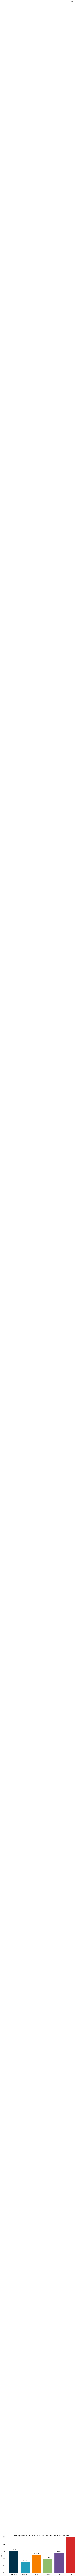

<Figure size 800x600 with 0 Axes>

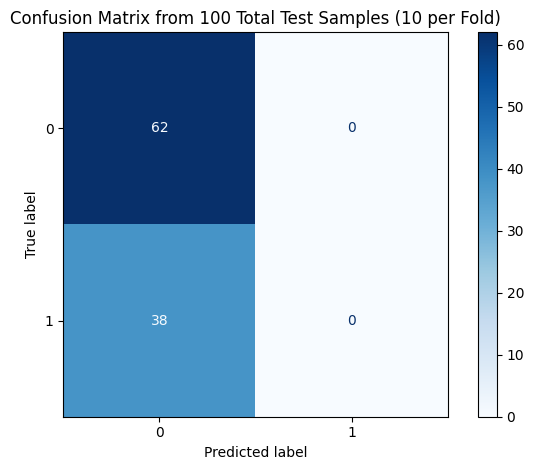

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import gc
import random
data_dir = '/kaggle/working/merged_images'
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    seed=42,
    shuffle=True,
    batch_size=13
)
all_samples = list(full_dataset.unbatch())
images = [sample[0] for sample in all_samples]
labels = [sample[1] for sample in all_samples]
X = tf.stack(images)
y = tf.stack(labels)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies, precisions, recalls, f1s, aucs, losses = [], [], [], [], [], []
all_y_true = []
all_y_pred = []
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'Fold {fold+1}/10')
    X_train, X_test_full = tf.gather(X, train_index), tf.gather(X, test_index)
    y_train, y_test_full = tf.gather(y, train_index), tf.gather(y, test_index)
    total_test_samples = X_test_full.shape[0]
    indices = random.sample(range(total_test_samples), min(10, total_test_samples))
    X_test = tf.gather(X_test_full, indices)
    y_test = tf.gather(y_test_full, indices)
    test_results = model.evaluate(X_test, y_test, verbose=0)
    loss = test_results[0]
    accuracy = test_results[1]
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test.numpy(), axis=1)
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    try:
        auc = roc_auc_score(y_test.numpy(), y_pred_probs, multi_class='ovr')
    except ValueError:
        auc = 0.0
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    aucs.append(auc)
    losses.append(loss)
    gc.collect()
avg_metrics = {
    'Accuracy': np.mean(accuracies),
    'Precision': np.mean(precisions),
    'Recall': np.mean(recalls),
    'F1-Score': np.mean(f1s),
    'ROC AUC': np.mean(aucs),
    'Loss': np.mean(losses)
}
plt.figure(figsize=(10, 5))
colors = ['#003049', '#219ebc', '#f77f00', '#90be6d', '#6a4c93', '#d62828']
bars = plt.bar(avg_metrics.keys(), avg_metrics.values(), color=colors)
plt.ylim(0, 1)
plt.title('Average Metrics over 10 Folds (10 Random Samples per Fold)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('average_metrics_10fold_limited.png')
plt.show()
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix from 100 Total Test Samples (10 per Fold)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix_100samples.png')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-82-a0b8741b6e85>:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


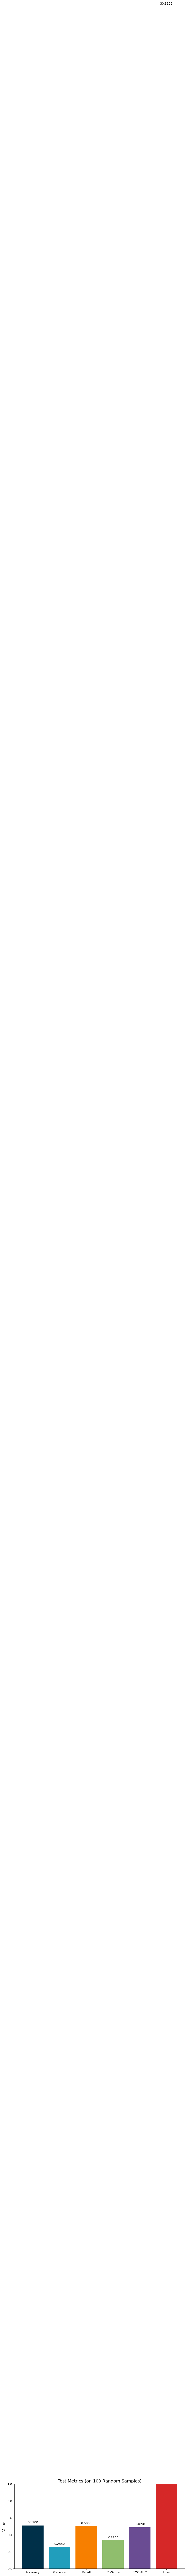

In [ ]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels_tensor.numpy(), axis=1)
test_results = model.evaluate(test_images_tensor, test_labels_tensor, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = precision_score(true_classes, predicted_classes, average='macro')
test_recall = recall_score(true_classes, predicted_classes, average='macro')
test_f1 = f1_score(true_classes, predicted_classes, average='macro')
try:
    test_roc_auc = roc_auc_score(test_labels_tensor.numpy(), predictions, multi_class='ovr')
except ValueError:
    test_roc_auc = 0.0
test_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Loss']
test_values = [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, test_loss]
plt.figure(figsize=(10, 5))
colors = ['#003049', '#219ebc', '#f77f00', '#90be6d', '#6a4c93', '#d62828']
bars = plt.bar(test_metrics, test_values, color=colors)
plt.ylim(0, 1)
plt.title('Test Metrics (on 100 Random Samples)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('test_metrics_bar_custom_classification.png')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 395ms/step


<Figure size 800x600 with 0 Axes>

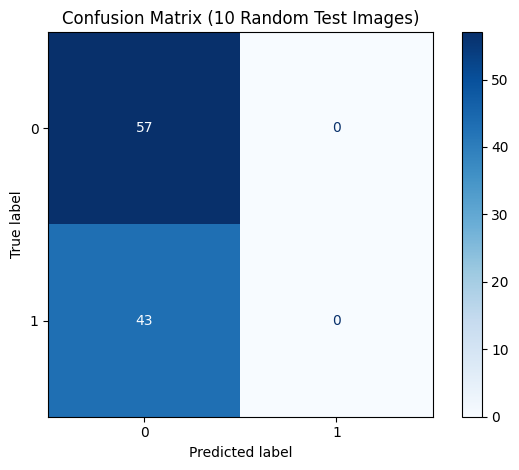

In [ ]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
y_true = np.argmax(test_labels_tensor.numpy(), axis=1)
y_pred = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (10 Random Test Images)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

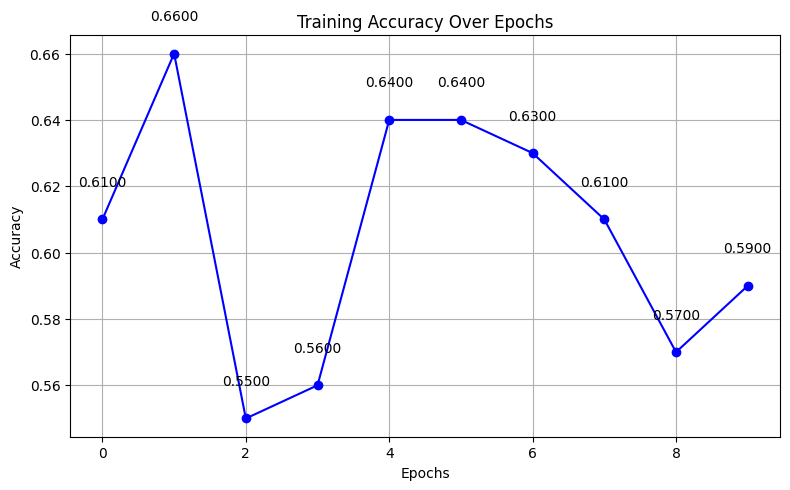

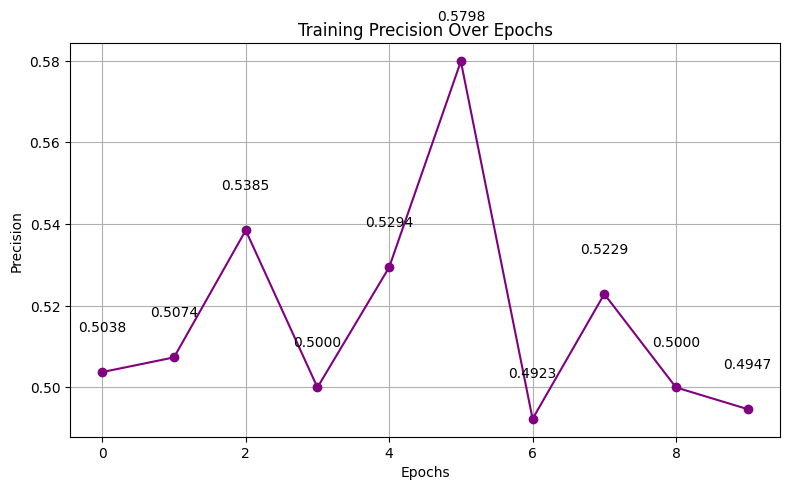

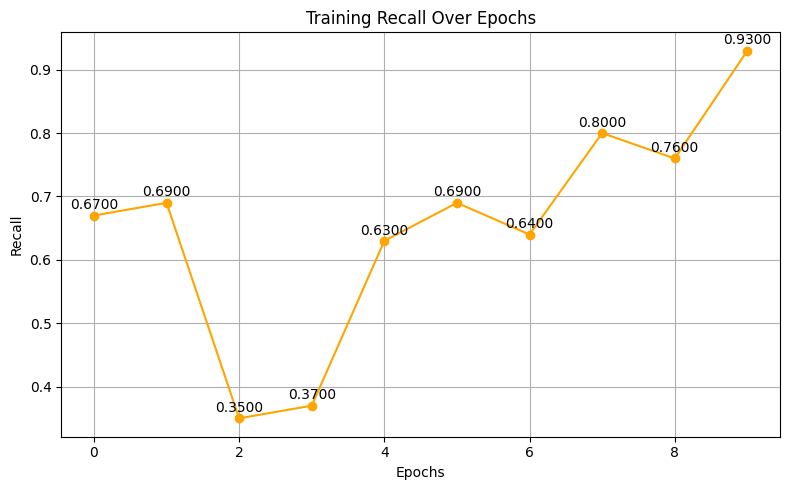

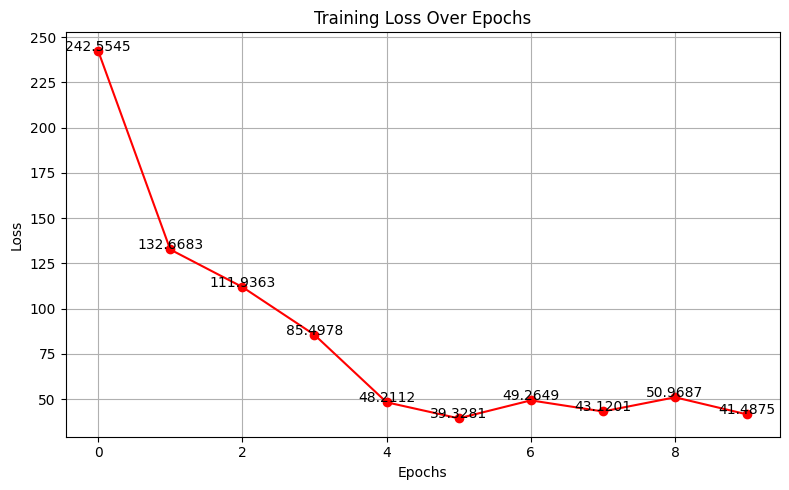

In [ ]:
epochs = range(len(history.history['accuracy']))
train_accuracy = history.history['accuracy']
train_precision = history.history['precision']
train_recall = history.history['recall']
train_loss = history.history['loss']
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
for i, acc in enumerate(train_accuracy):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_accuracy.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_precision, label='Train Precision', color='purple', marker='o')
plt.title('Training Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.grid()
for i, prec in enumerate(train_precision):
    plt.text(i, prec + 0.01, f"{prec:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_precision.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_recall, label='Train Recall', color='orange', marker='o')
plt.title('Training Recall Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.grid()
for i, rec in enumerate(train_recall):
    plt.text(i, rec + 0.01, f"{rec:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_recall.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Train Loss', color='red', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
for i, loss in enumerate(train_loss):
    plt.text(i, loss + 0.01, f"{loss:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_loss.png')
plt.show()


<div dir="rtl">
همونطور که دیدیم مدل ANN به هیچ عنوان قابل قبول نیست و دقت خوبی ندارد پس به دنبال بهبود بخشیدن مدل ما از یک مدل دیگر با عنوان CNN که این مدل بیشتر برای مدل های تصویر استفاده میشود ما علاوه بر این تغییر برای بهبود بخشیدن مدلمان یک کاری که میکنیم این است که ما از یک مدل از پیش اموزش دیده نیز استفاده خواهیم کرد به این صورت که لایه های ان مدل را فریز میکنیم تا تغییر نکند و بعد لایه های خودمان را بهش اضافه میکنیم ما دو لایه به اخر مدل از پیش اموزش دیده خودمان اضافه میکنیم و لایه اخر را نیز تابع فعالسازش را برابر sigmiod میگذاریم و میبینیم که مدلمان به شدت بهتر خواهد شد نام مدل از پیش اموزش دیده ما EfficientNetV2L است و این مدل را مانند مدل قبل بررسی میکنیم ان هم در ۴ مرحله
</div>

Found 1588 files belonging to 2 classes.
Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


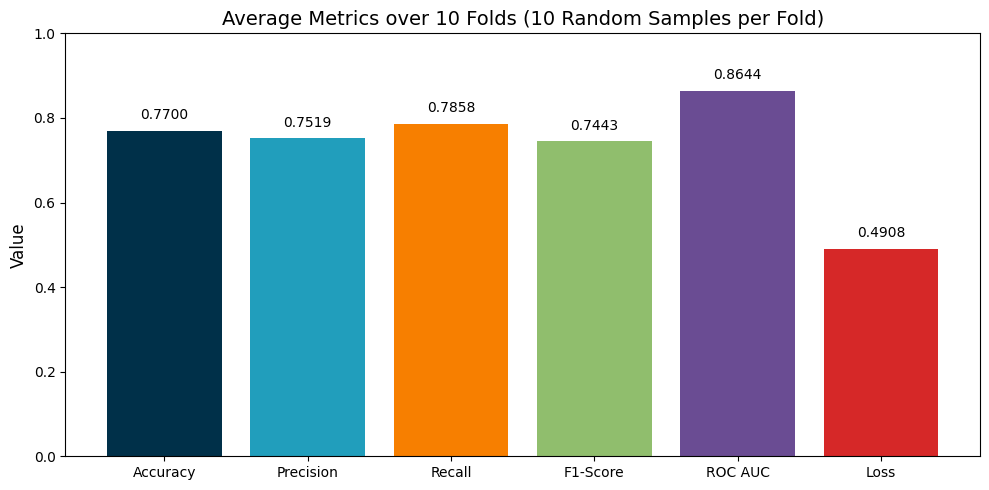

<Figure size 800x600 with 0 Axes>

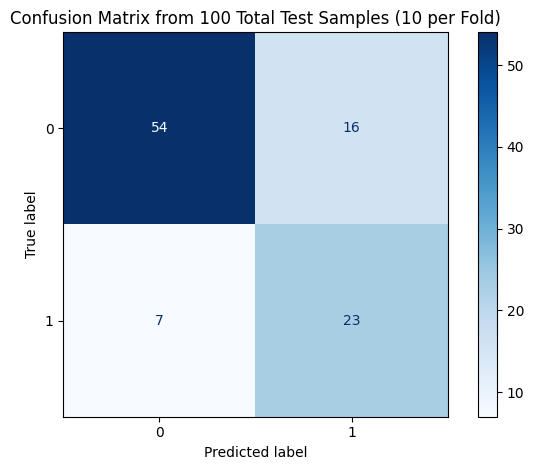

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import gc
import random
data_dir = '/kaggle/working/merged_images'
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    seed=42,
    shuffle=True,
    batch_size=13
)
all_samples = list(full_dataset.unbatch())
images = [sample[0] for sample in all_samples]
labels = [sample[1] for sample in all_samples]
X = tf.stack(images)
y = tf.stack(labels)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies, precisions, recalls, f1s, aucs, losses = [], [], [], [], [], []
all_y_true = []
all_y_pred = []
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'Fold {fold+1}/10')
    X_train, X_test_full = tf.gather(X, train_index), tf.gather(X, test_index)
    y_train, y_test_full = tf.gather(y, train_index), tf.gather(y, test_index)
    total_test_samples = X_test_full.shape[0]
    indices = random.sample(range(total_test_samples), min(10, total_test_samples))
    X_test = tf.gather(X_test_full, indices)
    y_test = tf.gather(y_test_full, indices)
    test_results = model.evaluate(X_test, y_test, verbose=0)
    loss = test_results[0]
    accuracy = test_results[1]
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test.numpy(), axis=1)
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    try:
        auc = roc_auc_score(y_test.numpy(), y_pred_probs, multi_class='ovr')
    except ValueError:
        auc = 0.0
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    aucs.append(auc)
    losses.append(loss)
    gc.collect()
avg_metrics = {
    'Accuracy': np.mean(accuracies),
    'Precision': np.mean(precisions),
    'Recall': np.mean(recalls),
    'F1-Score': np.mean(f1s),
    'ROC AUC': np.mean(aucs),
    'Loss': np.mean(losses)
}
plt.figure(figsize=(10, 5))
colors = ['#003049', '#219ebc', '#f77f00', '#90be6d', '#6a4c93', '#d62828']
bars = plt.bar(avg_metrics.keys(), avg_metrics.values(), color=colors)
plt.ylim(0, 1)
plt.title('Average Metrics over 10 Folds (10 Random Samples per Fold)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('average_metrics_10fold_limited.png')
plt.show()
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix from 100 Total Test Samples (10 per Fold)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix_100samples.png')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 74s 13s/step


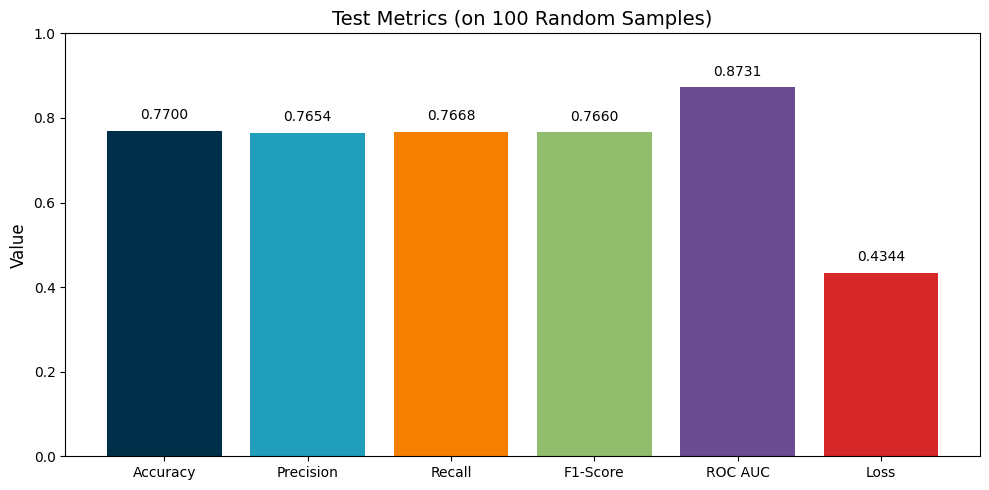

In [ ]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels_tensor.numpy(), axis=1)
test_results = model.evaluate(test_images_tensor, test_labels_tensor, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = precision_score(true_classes, predicted_classes, average='macro')
test_recall = recall_score(true_classes, predicted_classes, average='macro')
test_f1 = f1_score(true_classes, predicted_classes, average='macro')
try:
    test_roc_auc = roc_auc_score(test_labels_tensor.numpy(), predictions, multi_class='ovr')
except ValueError:
    test_roc_auc = 0.0
test_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Loss']
test_values = [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, test_loss]
plt.figure(figsize=(10, 5))
colors = ['#003049', '#219ebc', '#f77f00', '#90be6d', '#6a4c93', '#d62828']
bars = plt.bar(test_metrics, test_values, color=colors)
plt.ylim(0, 1)
plt.title('Test Metrics (on 100 Random Samples)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('test_metrics_bar_custom_classification.png')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 56s 12s/step


<Figure size 800x600 with 0 Axes>

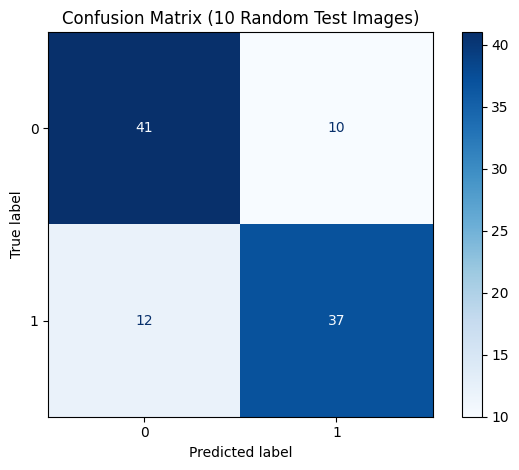

In [ ]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
y_true = np.argmax(test_labels_tensor.numpy(), axis=1)
y_pred = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (10 Random Test Images)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

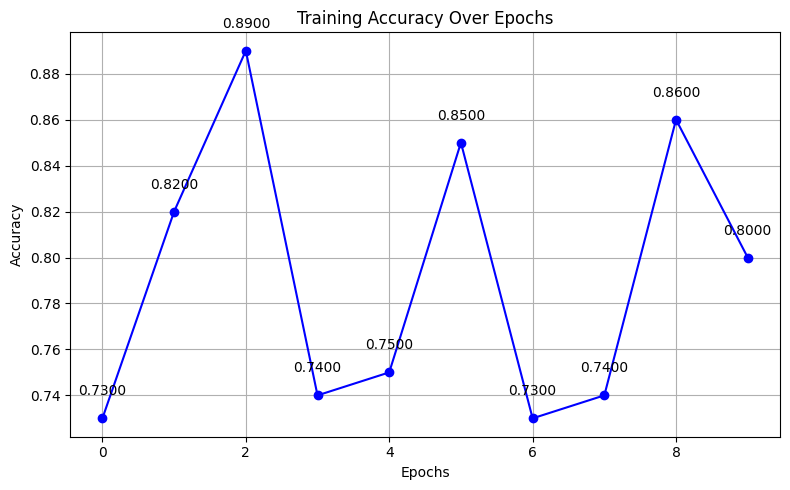

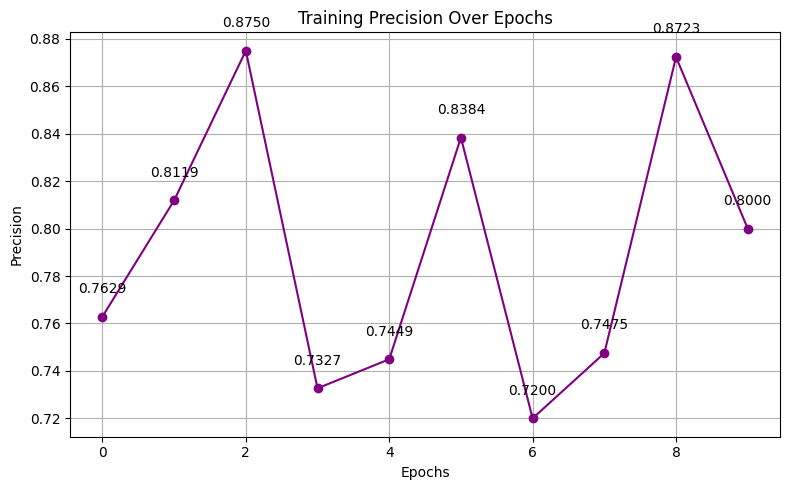

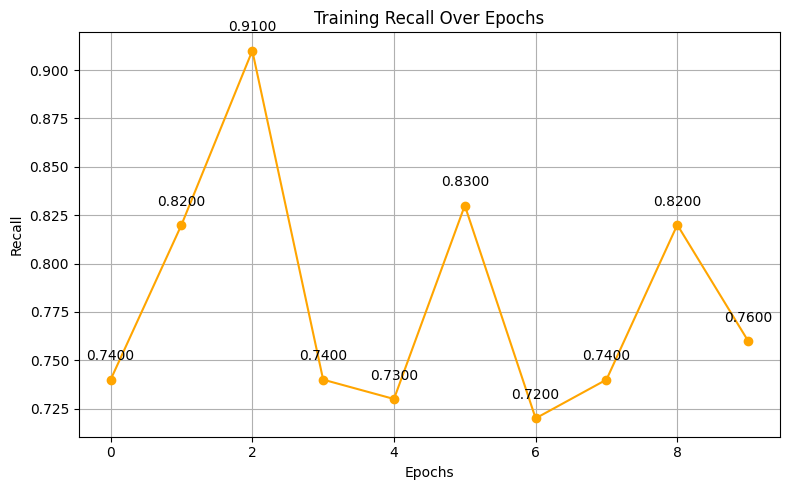

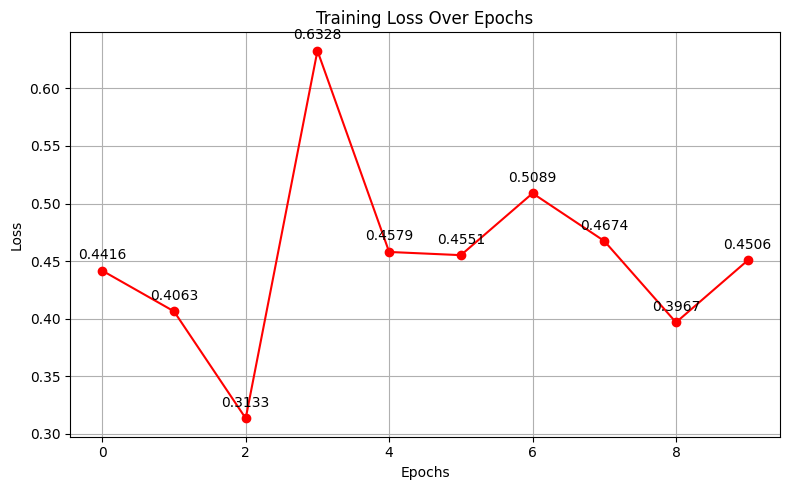

In [ ]:
epochs = range(len(history.history['accuracy']))
train_accuracy = history.history['accuracy']
train_precision = history.history['precision']
train_recall = history.history['recall']
train_loss = history.history['loss']
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
for i, acc in enumerate(train_accuracy):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_accuracy.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_precision, label='Train Precision', color='purple', marker='o')
plt.title('Training Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.grid()
for i, prec in enumerate(train_precision):
    plt.text(i, prec + 0.01, f"{prec:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_precision.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_recall, label='Train Recall', color='orange', marker='o')
plt.title('Training Recall Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.grid()
for i, rec in enumerate(train_recall):
    plt.text(i, rec + 0.01, f"{rec:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_recall.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Train Loss', color='red', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
for i, loss in enumerate(train_loss):
    plt.text(i, loss + 0.01, f"{loss:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_loss.png')
plt.show()

<div dir="rtl">
با توجه به اینکه خیلی مدل ما بهتر شده در راستای بهتر  کردن مدل مان و جواب های دریافتی در نتیجه‌ی تحقیقات به این نتیجه رسیدم که اگر تابع فعالساز لایه اخر را    به   تغییرر بدم دقت مدل بهتر خواهد شد     
</div>

Found 1588 files belonging to 2 classes.
Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


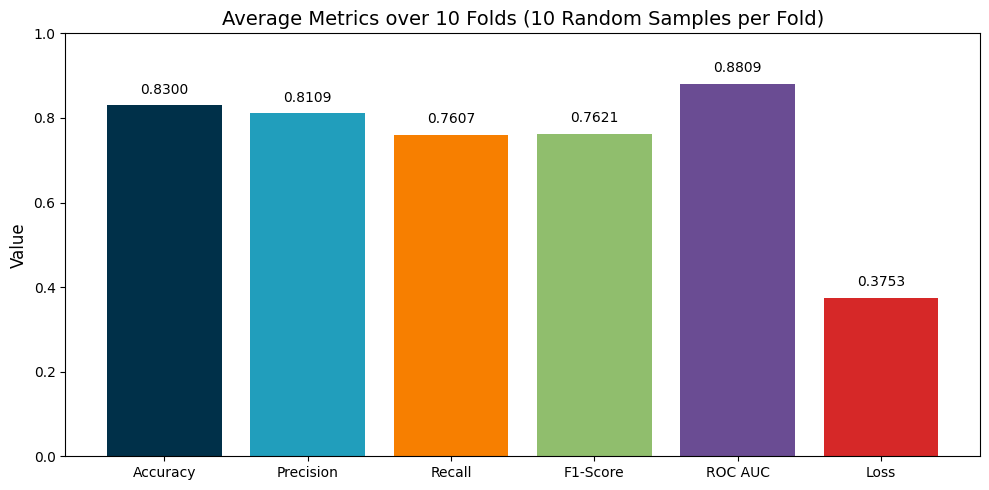

<Figure size 800x600 with 0 Axes>

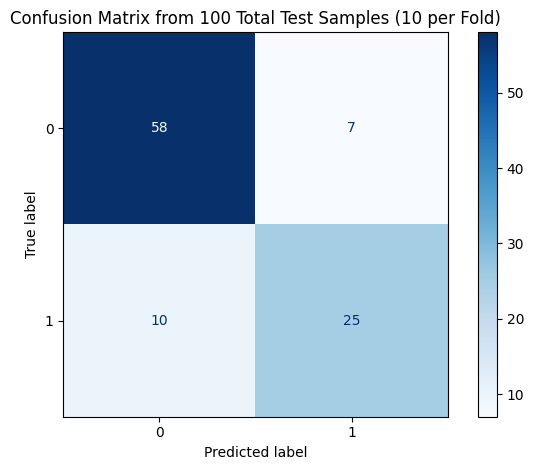

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import gc
import random
data_dir = '/kaggle/working/merged_images'
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    seed=42,
    shuffle=True,
    batch_size=13
)
all_samples = list(full_dataset.unbatch())
images = [sample[0] for sample in all_samples]
labels = [sample[1] for sample in all_samples]
X = tf.stack(images)
y = tf.stack(labels)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies, precisions, recalls, f1s, aucs, losses = [], [], [], [], [], []
all_y_true = []
all_y_pred = []
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'Fold {fold+1}/10')
    X_train, X_test_full = tf.gather(X, train_index), tf.gather(X, test_index)
    y_train, y_test_full = tf.gather(y, train_index), tf.gather(y, test_index)
    total_test_samples = X_test_full.shape[0]
    indices = random.sample(range(total_test_samples), min(10, total_test_samples))
    X_test = tf.gather(X_test_full, indices)
    y_test = tf.gather(y_test_full, indices)
    test_results = model.evaluate(X_test, y_test, verbose=0)
    loss = test_results[0]
    accuracy = test_results[1]
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test.numpy(), axis=1)
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    try:
        auc = roc_auc_score(y_test.numpy(), y_pred_probs, multi_class='ovr')
    except ValueError:
        auc = 0.0
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    aucs.append(auc)
    losses.append(loss)
    gc.collect()
avg_metrics = {
    'Accuracy': np.mean(accuracies),
    'Precision': np.mean(precisions),
    'Recall': np.mean(recalls),
    'F1-Score': np.mean(f1s),
    'ROC AUC': np.mean(aucs),
    'Loss': np.mean(losses)
}
plt.figure(figsize=(10, 5))
colors = ['#003049', '#219ebc', '#f77f00', '#90be6d', '#6a4c93', '#d62828']
bars = plt.bar(avg_metrics.keys(), avg_metrics.values(), color=colors)
plt.ylim(0, 1)
plt.title('Average Metrics over 10 Folds (10 Random Samples per Fold)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('average_metrics_10fold_limited.png')
plt.show()
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix from 100 Total Test Samples (10 per Fold)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix_100samples.png')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 72s 13s/step


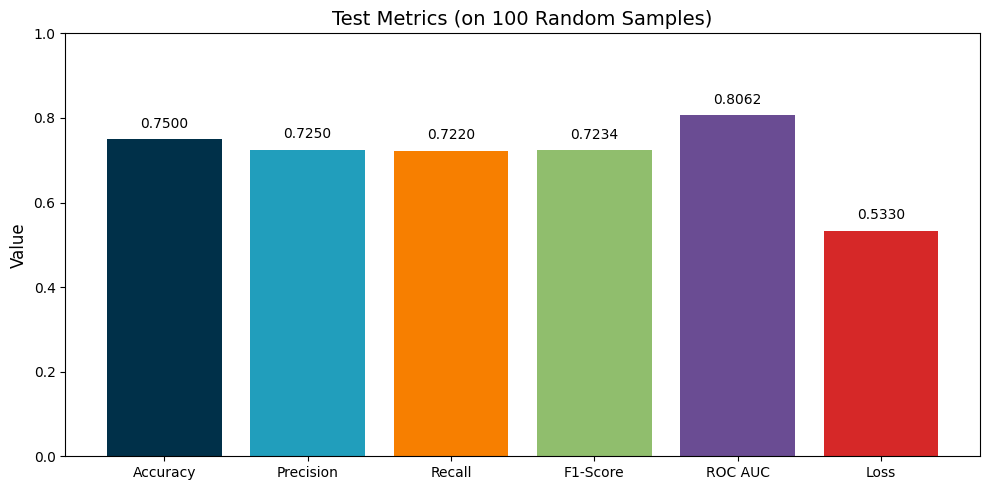

In [ ]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels_tensor.numpy(), axis=1)
test_results = model.evaluate(test_images_tensor, test_labels_tensor, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = precision_score(true_classes, predicted_classes, average='macro')
test_recall = recall_score(true_classes, predicted_classes, average='macro')
test_f1 = f1_score(true_classes, predicted_classes, average='macro')
try:
    test_roc_auc = roc_auc_score(test_labels_tensor.numpy(), predictions, multi_class='ovr')
except ValueError:
    test_roc_auc = 0.0
test_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Loss']
test_values = [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, test_loss]
plt.figure(figsize=(10, 5))
colors = ['#003049', '#219ebc', '#f77f00', '#90be6d', '#6a4c93', '#d62828']
bars = plt.bar(test_metrics, test_values, color=colors)
plt.ylim(0, 1)
plt.title('Test Metrics (on 100 Random Samples)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('test_metrics_bar_custom_classification.png')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 61s 13s/step


<Figure size 800x600 with 0 Axes>

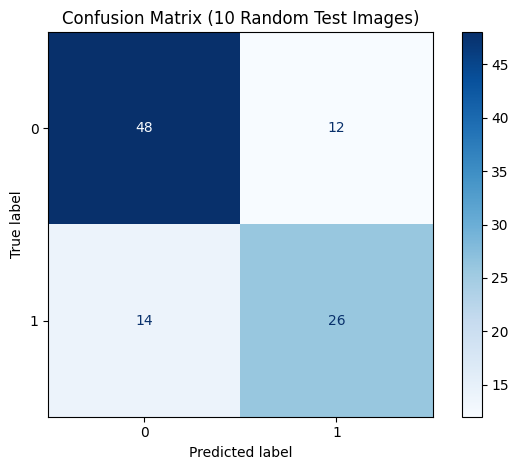

In [ ]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
y_true = np.argmax(test_labels_tensor.numpy(), axis=1)
y_pred = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (10 Random Test Images)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

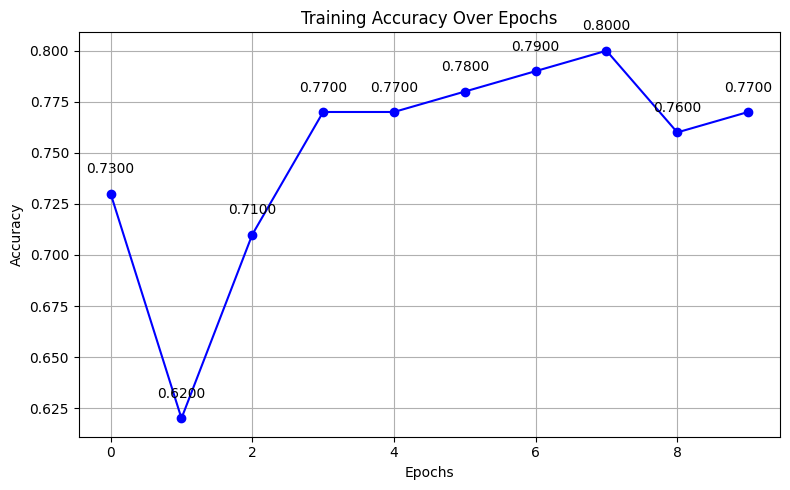

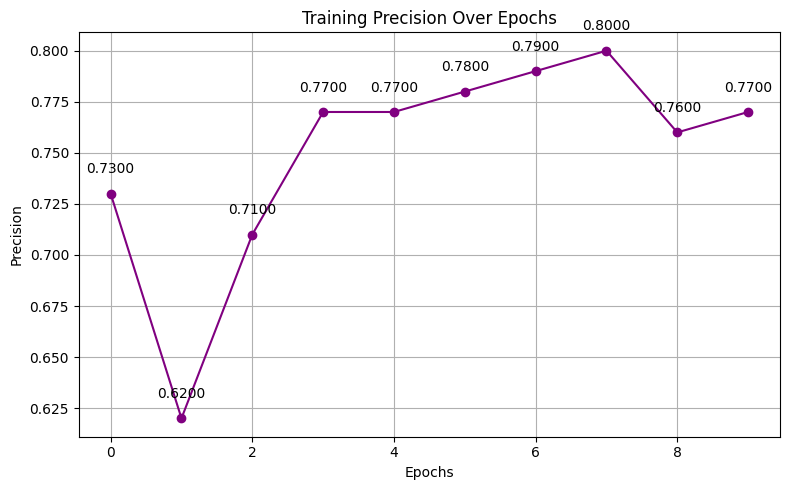

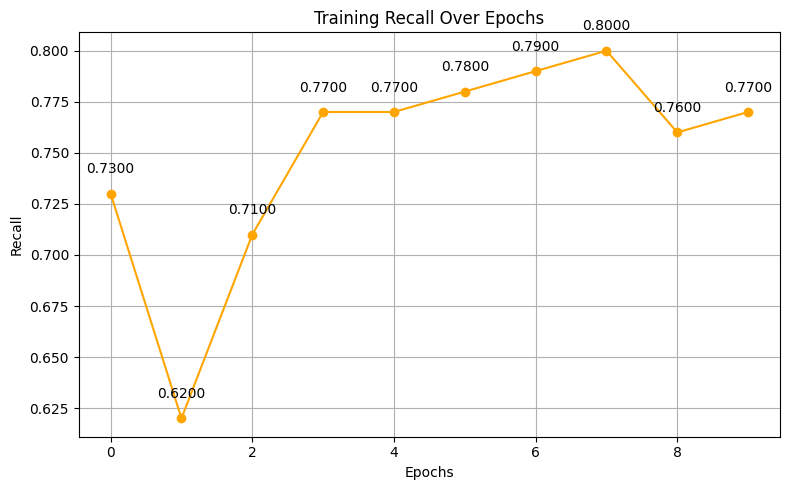

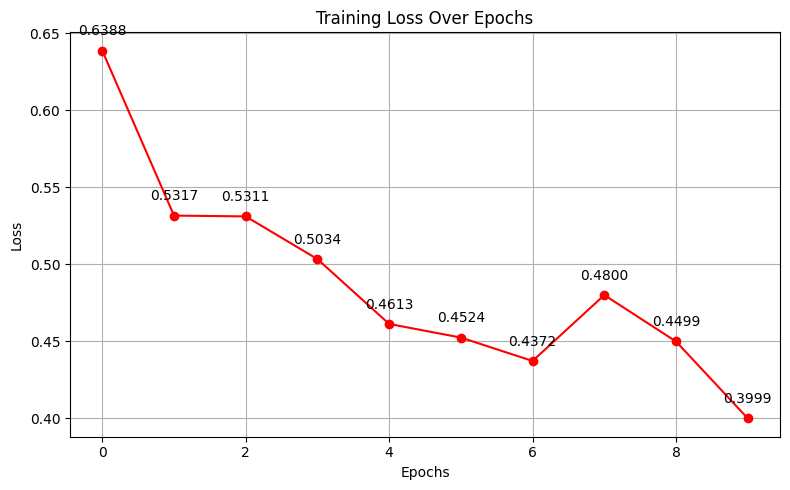

In [ ]:
epochs = range(len(history.history['accuracy']))
train_accuracy = history.history['accuracy']
train_precision = history.history['precision']
train_recall = history.history['recall']
train_loss = history.history['loss']
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
for i, acc in enumerate(train_accuracy):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_accuracy.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_precision, label='Train Precision', color='purple', marker='o')
plt.title('Training Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.grid()
for i, prec in enumerate(train_precision):
    plt.text(i, prec + 0.01, f"{prec:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_precision.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_recall, label='Train Recall', color='orange', marker='o')
plt.title('Training Recall Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.grid()
for i, rec in enumerate(train_recall):
    plt.text(i, rec + 0.01, f"{rec:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_recall.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Train Loss', color='red', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
for i, loss in enumerate(train_loss):
    plt.text(i, loss + 0.01, f"{loss:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_loss.png')
plt.show()

<div dir="rtl">
در تلاش برای بهتر کردن مدلمان و نتایج ما به این نتیجه رسیدم که طبق تجربه اگر تصاویر را آگمنت کنم دقت مدل افزایش پیدا خواهد کرد در روند دیتاآگمنتیشن ما یکسری فاکتور های عکس را تغییر میدهیم از جمله تصویر را میچرخوانیم کانتراست ان را تغییر میدهیم و روشنایی انرا تغییر میدهیم و ... که در نتیجه این مدل ما بهتر خواهد شد و علاوه بر این بالانس بودن دیتا نیز کمک زیادی به بهبود مدل ما خواهد کرد به این معنی که تعداد عکس های بیمار و سالم با هم برابر باشد که ما تعداد این را با استفاده همان دیتا اگمنتیشن که پیشتر توضیح دادم بهبود بخشیدم
</div>

Found 9976 files belonging to 2 classes.
Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


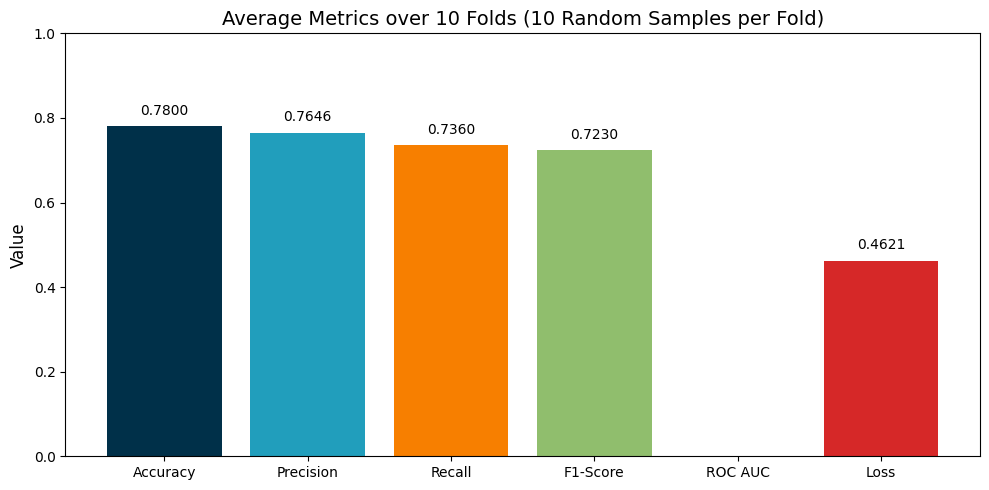

<Figure size 800x600 with 0 Axes>

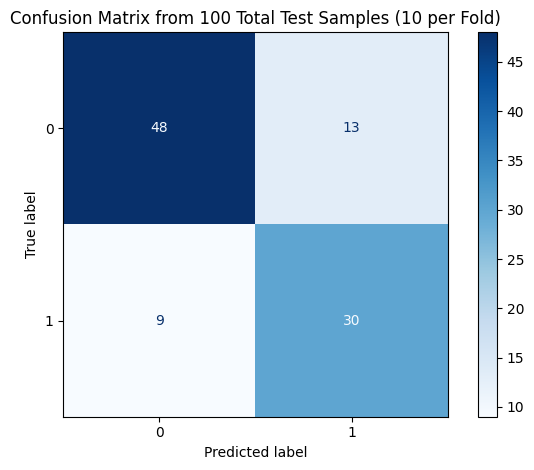

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import gc
import random
data_dir = '/kaggle/working/merged_images'
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    seed=42,
    shuffle=True,
    batch_size=13
)
all_samples = list(full_dataset.unbatch())
images = [sample[0] for sample in all_samples]
labels = [sample[1] for sample in all_samples]
X = tf.stack(images)
y = tf.stack(labels)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies, precisions, recalls, f1s, aucs, losses = [], [], [], [], [], []
all_y_true = []
all_y_pred = []
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'Fold {fold+1}/10')
    X_train, X_test_full = tf.gather(X, train_index), tf.gather(X, test_index)
    y_train, y_test_full = tf.gather(y, train_index), tf.gather(y, test_index)
    total_test_samples = X_test_full.shape[0]
    indices = random.sample(range(total_test_samples), min(10, total_test_samples))
    X_test = tf.gather(X_test_full, indices)
    y_test = tf.gather(y_test_full, indices)
    test_results = model.evaluate(X_test, y_test, verbose=0)
    loss = test_results[0]
    accuracy = test_results[1]
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test.numpy(), axis=1)
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    try:
        auc = roc_auc_score(y_test.numpy(), y_pred_probs, multi_class='ovr')
    except ValueError:
        auc = 0.0
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    aucs.append(auc)
    losses.append(loss)
    gc.collect()
avg_metrics = {
    'Accuracy': np.mean(accuracies),
    'Precision': np.mean(precisions),
    'Recall': np.mean(recalls),
    'F1-Score': np.mean(f1s),
    'ROC AUC': np.mean(aucs),
    'Loss': np.mean(losses)
}
plt.figure(figsize=(10, 5))
colors = ['#003049', '#219ebc', '#f77f00', '#90be6d', '#6a4c93', '#d62828']
bars = plt.bar(avg_metrics.keys(), avg_metrics.values(), color=colors)
plt.ylim(0, 1)
plt.title('Average Metrics over 10 Folds (10 Random Samples per Fold)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('average_metrics_10fold_limited.png')
plt.show()
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix from 100 Total Test Samples (10 per Fold)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix_100samples.png')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 71s 15s/step


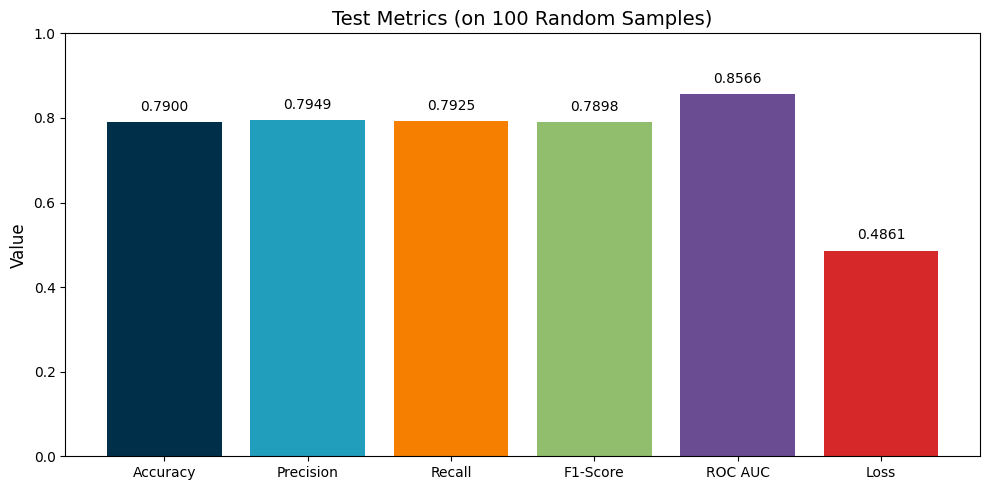

In [ ]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels_tensor.numpy(), axis=1)
test_results = model.evaluate(test_images_tensor, test_labels_tensor, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = precision_score(true_classes, predicted_classes, average='macro')
test_recall = recall_score(true_classes, predicted_classes, average='macro')
test_f1 = f1_score(true_classes, predicted_classes, average='macro')
try:
    test_roc_auc = roc_auc_score(test_labels_tensor.numpy(), predictions, multi_class='ovr')
except ValueError:
    test_roc_auc = 0.0
test_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Loss']
test_values = [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, test_loss]
plt.figure(figsize=(10, 5))
colors = ['#003049', '#219ebc', '#f77f00', '#90be6d', '#6a4c93', '#d62828']
bars = plt.bar(test_metrics, test_values, color=colors)
plt.ylim(0, 1)
plt.title('Test Metrics (on 100 Random Samples)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('test_metrics_bar_custom_classification.png')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 64s 14s/step


<Figure size 800x600 with 0 Axes>

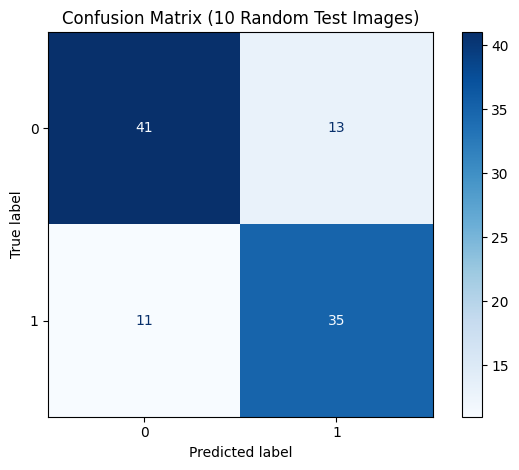

In [ ]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
y_true = np.argmax(test_labels_tensor.numpy(), axis=1)
y_pred = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (10 Random Test Images)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

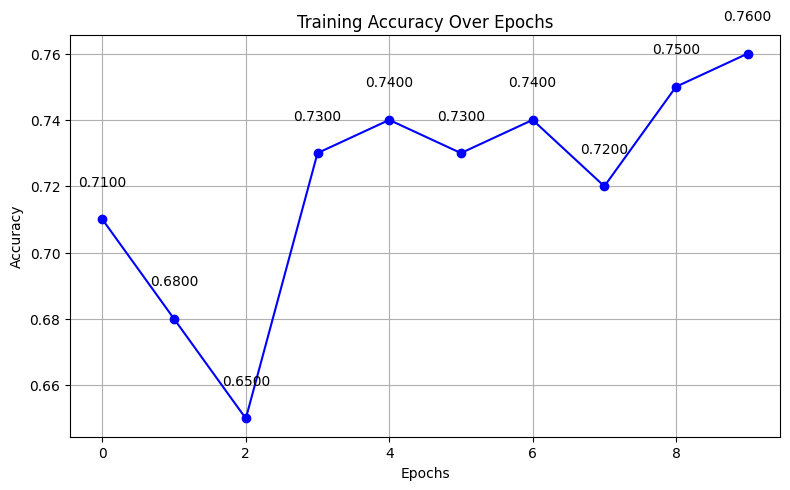

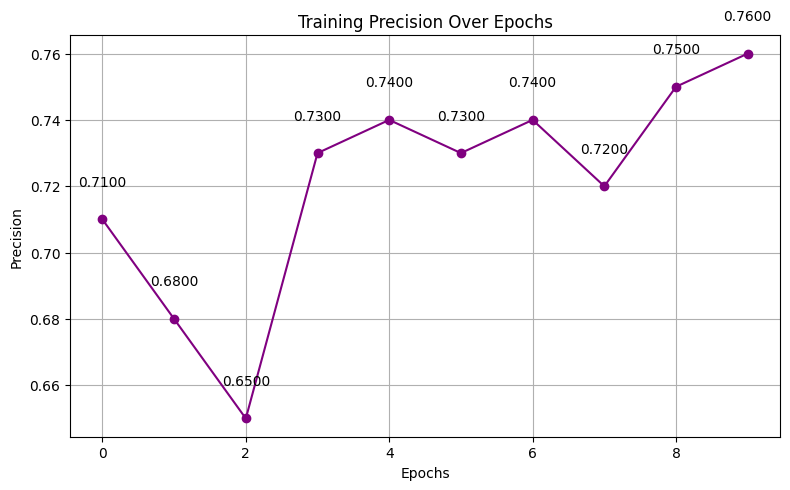

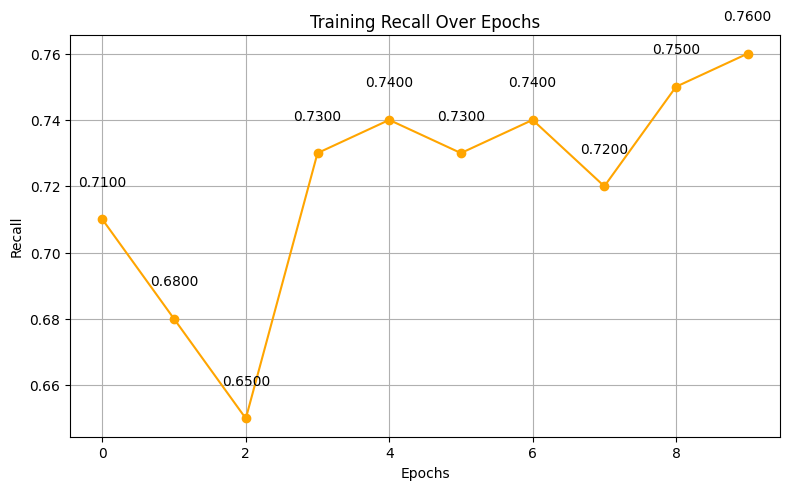

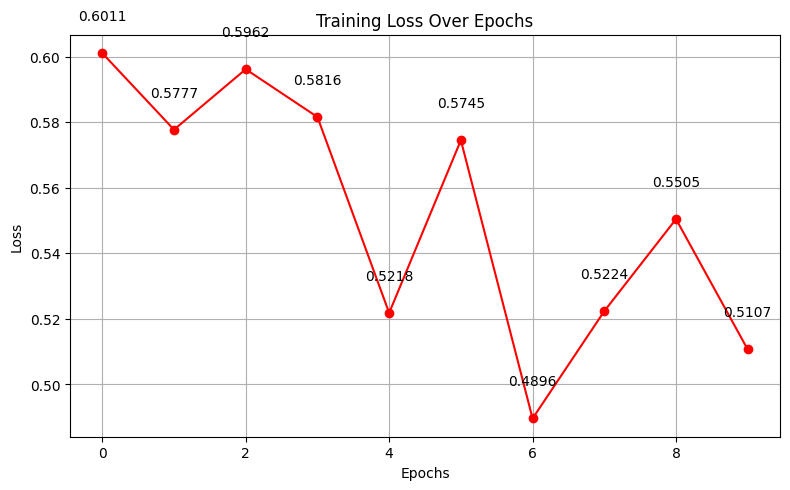

In [ ]:
epochs = range(len(history.history['accuracy']))
train_accuracy = history.history['accuracy']
train_precision = history.history['precision']
train_recall = history.history['recall']
train_loss = history.history['loss']
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
for i, acc in enumerate(train_accuracy):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_accuracy.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_precision, label='Train Precision', color='purple', marker='o')
plt.title('Training Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.grid()
for i, prec in enumerate(train_precision):
    plt.text(i, prec + 0.01, f"{prec:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_precision.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_recall, label='Train Recall', color='orange', marker='o')
plt.title('Training Recall Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.grid()
for i, rec in enumerate(train_recall):
    plt.text(i, rec + 0.01, f"{rec:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_recall.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Train Loss', color='red', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
for i, loss in enumerate(train_loss):
    plt.text(i, loss + 0.01, f"{loss:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_loss.png')
plt.show()

<div dir="rtl">
در نهایت به عنوان اخرین تلاش برای بهتر کردن مدل ما مدل از پیش اموزش دیده را به ConvNeXtBase تغییر میدهم که دقت مدل را به اندازه مطلوبی بهبود خواهد بخشید
</div>

Found 9976 files belonging to 2 classes.
Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


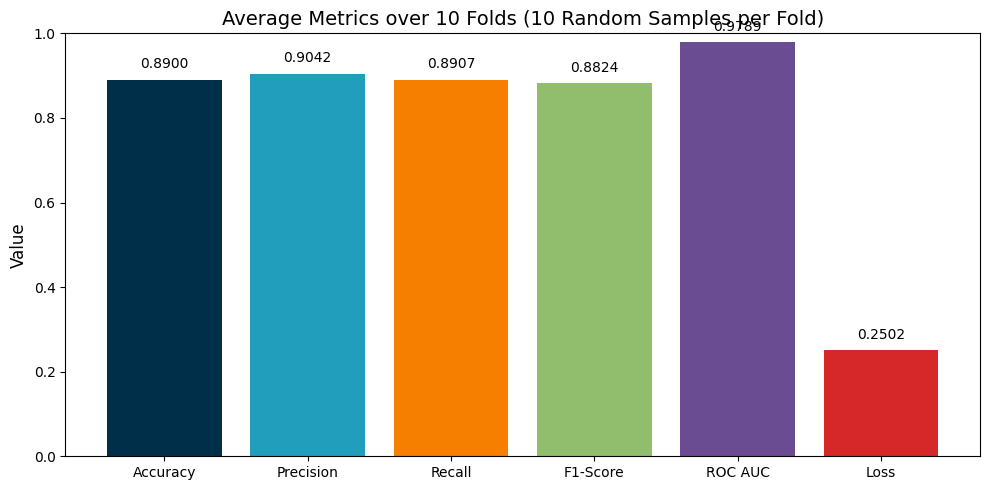

<Figure size 800x600 with 0 Axes>

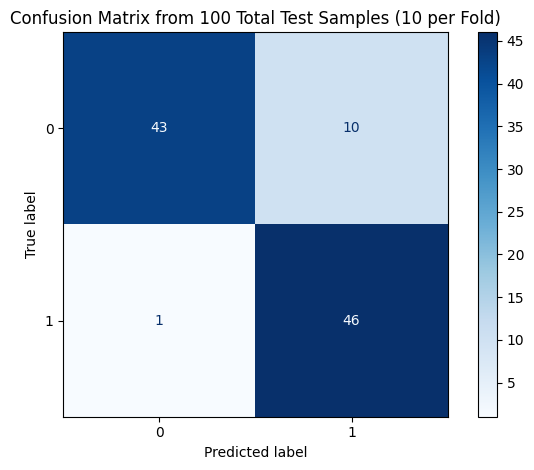

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import gc
import random
data_dir = '/kaggle/working/merged_images'
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    seed=42,
    shuffle=True,
    batch_size=13
)
all_samples = list(full_dataset.unbatch())
images = [sample[0] for sample in all_samples]
labels = [sample[1] for sample in all_samples]
X = tf.stack(images)
y = tf.stack(labels)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies, precisions, recalls, f1s, aucs, losses = [], [], [], [], [], []
all_y_true = []
all_y_pred = []
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'Fold {fold+1}/10')
    X_train, X_test_full = tf.gather(X, train_index), tf.gather(X, test_index)
    y_train, y_test_full = tf.gather(y, train_index), tf.gather(y, test_index)
    total_test_samples = X_test_full.shape[0]
    indices = random.sample(range(total_test_samples), min(10, total_test_samples))
    X_test = tf.gather(X_test_full, indices)
    y_test = tf.gather(y_test_full, indices)
    test_results = model.evaluate(X_test, y_test, verbose=0)
    loss = test_results[0]
    accuracy = test_results[1]
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test.numpy(), axis=1)
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    try:
        auc = roc_auc_score(y_test.numpy(), y_pred_probs, multi_class='ovr')
    except ValueError:
        auc = 0.0
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    aucs.append(auc)
    losses.append(loss)
    gc.collect()
avg_metrics = {
    'Accuracy': np.mean(accuracies),
    'Precision': np.mean(precisions),
    'Recall': np.mean(recalls),
    'F1-Score': np.mean(f1s),
    'ROC AUC': np.mean(aucs),
    'Loss': np.mean(losses)
}
plt.figure(figsize=(10, 5))
colors = ['#003049', '#219ebc', '#f77f00', '#90be6d', '#6a4c93', '#d62828']
bars = plt.bar(avg_metrics.keys(), avg_metrics.values(), color=colors)
plt.ylim(0, 1)
plt.title('Average Metrics over 10 Folds (10 Random Samples per Fold)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('average_metrics_10fold_limited.png')
plt.show()
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix from 100 Total Test Samples (10 per Fold)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix_100samples.png')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 212s 47s/step


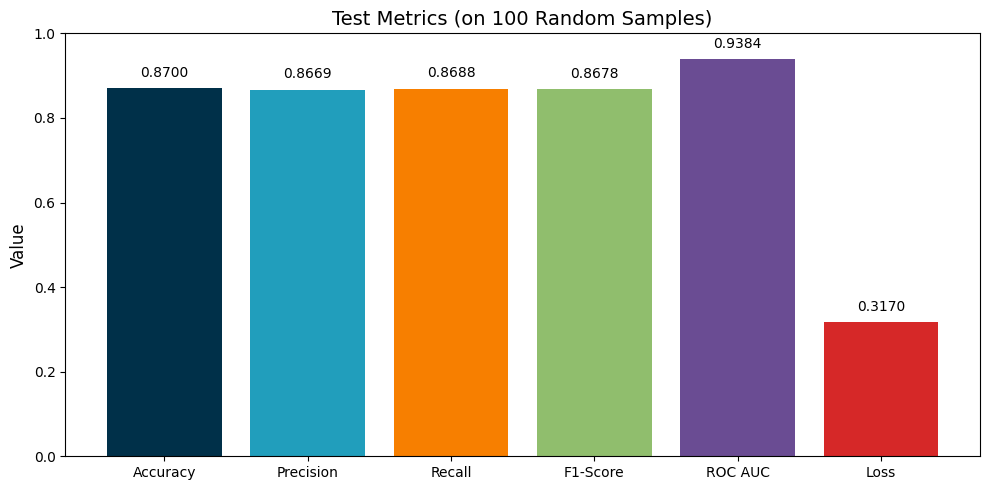

In [ ]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels_tensor.numpy(), axis=1)
test_results = model.evaluate(test_images_tensor, test_labels_tensor, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = precision_score(true_classes, predicted_classes, average='macro')
test_recall = recall_score(true_classes, predicted_classes, average='macro')
test_f1 = f1_score(true_classes, predicted_classes, average='macro')
try:
    test_roc_auc = roc_auc_score(test_labels_tensor.numpy(), predictions, multi_class='ovr')
except ValueError:
    test_roc_auc = 0.0
test_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Loss']
test_values = [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, test_loss]
plt.figure(figsize=(10, 5))
colors = ['#003049', '#219ebc', '#f77f00', '#90be6d', '#6a4c93', '#d62828']
bars = plt.bar(test_metrics, test_values, color=colors)
plt.ylim(0, 1)
plt.title('Test Metrics (on 100 Random Samples)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('test_metrics_bar_custom_classification.png')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 206s 47s/step


<Figure size 800x600 with 0 Axes>

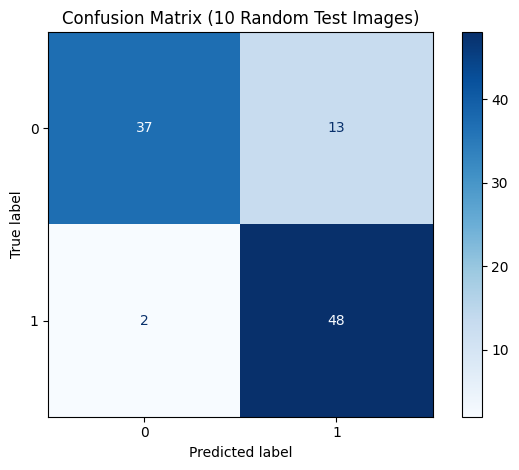

In [ ]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
y_true = np.argmax(test_labels_tensor.numpy(), axis=1)
y_pred = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (10 Random Test Images)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

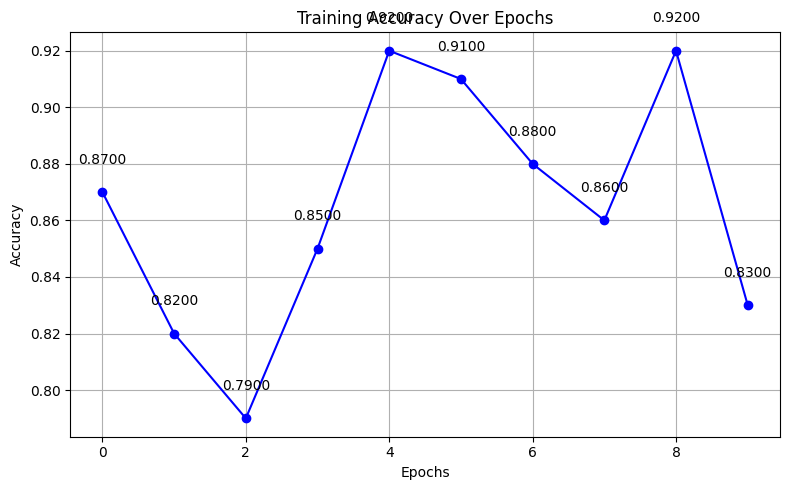

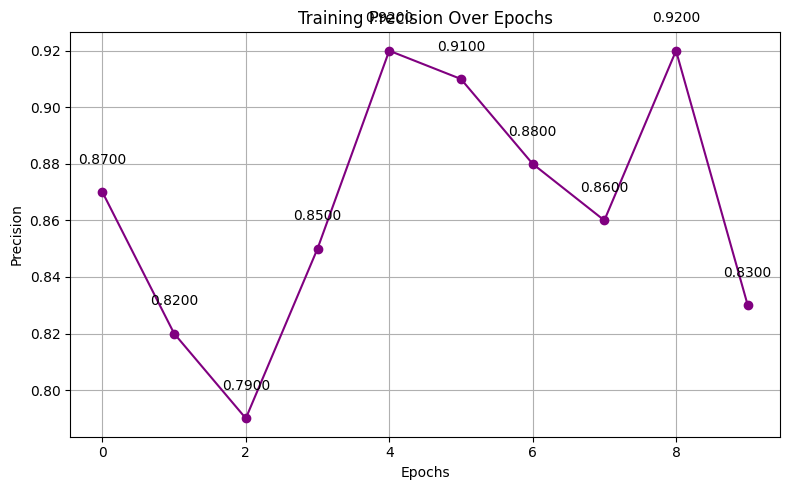

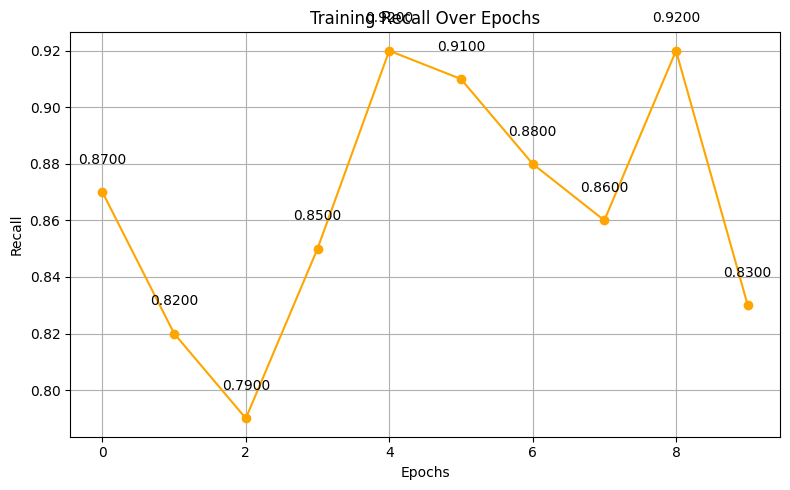

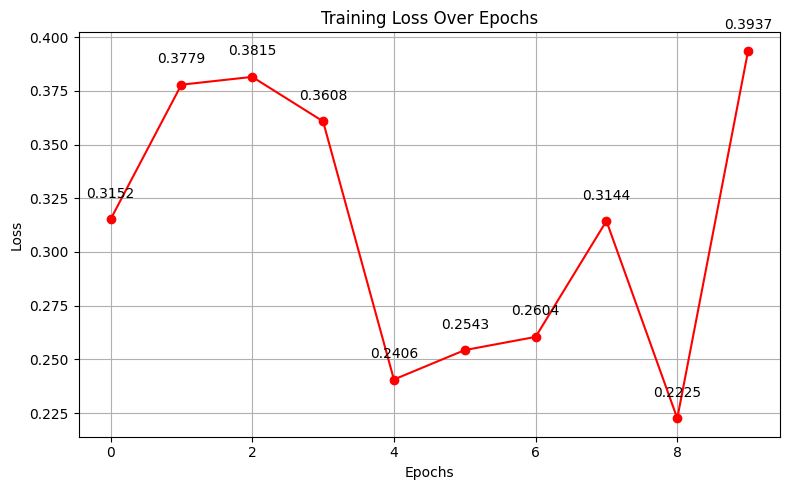

In [ ]:
epochs = range(len(history.history['accuracy']))
train_accuracy = history.history['accuracy']
train_precision = history.history['precision']
train_recall = history.history['recall']
train_loss = history.history['loss']
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
for i, acc in enumerate(train_accuracy):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_accuracy.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_precision, label='Train Precision', color='purple', marker='o')
plt.title('Training Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.grid()
for i, prec in enumerate(train_precision):
    plt.text(i, prec + 0.01, f"{prec:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_precision.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_recall, label='Train Recall', color='orange', marker='o')
plt.title('Training Recall Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.grid()
for i, rec in enumerate(train_recall):
    plt.text(i, rec + 0.01, f"{rec:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_recall.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Train Loss', color='red', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
for i, loss in enumerate(train_loss):
    plt.text(i, loss + 0.01, f"{loss:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_loss.png')
plt.show()

<div dir="rtl">



</div>

In [ ]:
from tensorflow.keras.utils import plot_model

###prediction

(224, 224, 3)


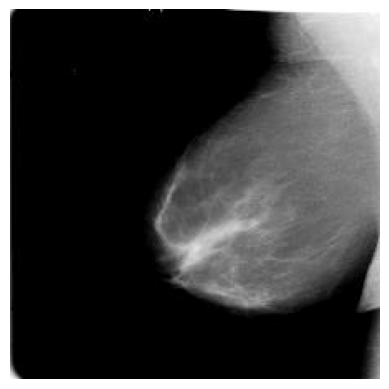

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Prediction Result: [[0.10681657 0.8931834 ]]


97614

In [ ]:
image_dir = '/kaggle/working/merged_images/0'
image_path = os.path.join(image_dir, os.listdir(image_dir)[0])
image = cv2.imread(image_path)
image = cv2.resize(image, (224, 224))
image = np.array(image)
print(image.shape)
image = image / 255.0
image = np.expand_dims(image, axis=0)
plt.imshow(image[0])
plt.axis('off')
plt.show()
result = model.predict(image)
print("Prediction Result:", result)
del image;    gc.collect()

(224, 224, 3)


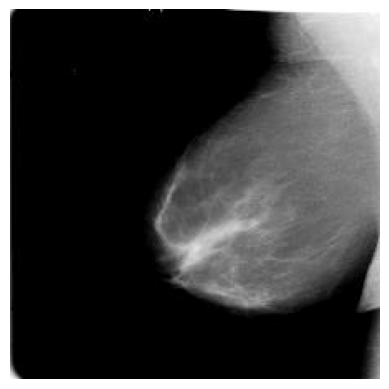

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
True Label: [1]
Predicted Label: [1]
Correct Prediction: [ True]


0

In [ ]:
image_dir = '/kaggle/working/merged_images/0'
image_path = os.path.join(image_dir, os.listdir(image_dir)[0])
test_data_list = list(test_dataset.unbatch())
image = cv2.imread(image_path)
first_sample = test_data_list[0]
image = cv2.resize(image, (224, 224))
test_image = first_sample[0]
test_label = first_sample[1]
test_image_tensor = tf.expand_dims(test_image, axis=0)
test_label_tensor = tf.expand_dims(test_label, axis=0)
image = np.array(image)
print(image.shape)
image = image / 255.0
image = np.expand_dims(image, axis=0)
plt.imshow(image[0])
plt.axis('off')
plt.show()
prediction = model.predict(test_image_tensor)
y_true = np.argmax(test_label_tensor.numpy(), axis=1)
y_pred = np.argmax(prediction, axis=1)
print("True Label:", y_true)
print("Predicted Label:", y_pred)
correct_prediction = (y_true == y_pred)
print("Correct Prediction:", correct_prediction)
del image;    gc.collect()
del test_image, test_label
gc.collect()

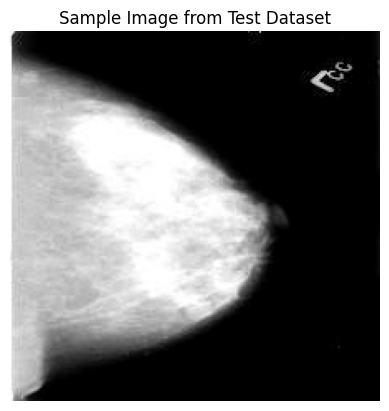

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
True Label: [1]
Predicted Label: [1]
Correct Prediction: [ True]


3062

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import gc
test_data_list = list(test_dataset.unbatch())
first_sample = test_data_list[10]
test_image = first_sample[0]
test_label = first_sample[1]
if tf.reduce_max(test_image) > 1.0:
    test_image = test_image / 255.0
plt.imshow(test_image.numpy())
plt.axis('off')
plt.title('Sample Image from Test Dataset')
plt.show()
test_image_tensor = tf.expand_dims(test_image, axis=0)
test_label_tensor = tf.expand_dims(test_label, axis=0)
prediction = model.predict(test_image_tensor)
y_true = np.argmax(test_label_tensor.numpy(), axis=1)
y_pred = np.argmax(prediction, axis=1)
print("True Label:", y_true)
print("Predicted Label:", y_pred)
correct_prediction = (y_true == y_pred)
print("Correct Prediction:", correct_prediction)
del test_image, test_label
gc.collect()

#2

(224, 224, 3)


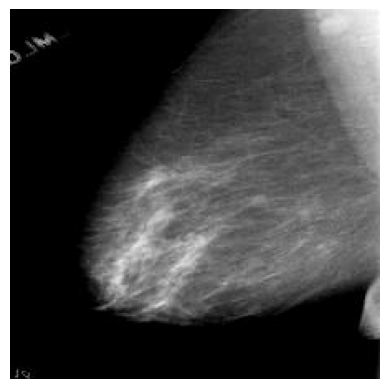

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
True Label: [0]
Predicted Label: [0]
Correct Prediction: [ True]


0

In [ ]:
image_dir = '/kaggle/working/merged_images/0'
image_path = os.path.join(image_dir, os.listdir(image_dir)[0])
test_data_list = list(test_dataset.unbatch())
image = cv2.imread(image_path)
first_sample = test_data_list[0]
image = cv2.resize(image, (224, 224))
test_image = first_sample[0]
test_label = first_sample[1]
test_image_tensor = tf.expand_dims(test_image, axis=0)
test_label_tensor = tf.expand_dims(test_label, axis=0)
image = np.array(image)
print(image.shape)
image = image / 255.0
image = np.expand_dims(image, axis=0)
plt.imshow(image[0])
plt.axis('off')
plt.show()
prediction = model.predict(test_image_tensor)
y_true = np.argmax(test_label_tensor.numpy(), axis=1)
y_pred = np.argmax(prediction, axis=1)
print("True Label:", y_true)
print("Predicted Label:", y_pred)
correct_prediction = (y_true == y_pred)
print("Correct Prediction:", correct_prediction)
del image;    gc.collect()
del test_image, test_label
gc.collect()

Found 9976 files belonging to 2 classes.


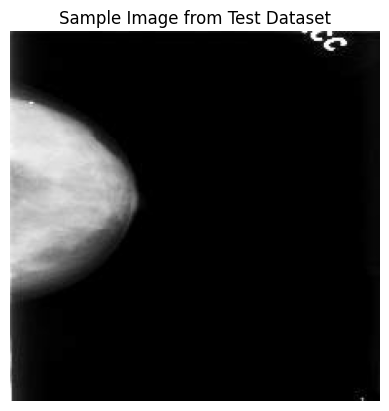

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
True Label: [0]
Predicted Label: [1]
Correct Prediction: [False]


3213

In [ ]:

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import gc
data_dir = '/kaggle/working/merged_images'
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    seed=30,
    shuffle=False,
    batch_size=13
)
limited_dataset = list(full_dataset.unbatch().take(100))
first_sample = limited_dataset[14]
test_image = first_sample[0]
test_label = first_sample[1]
if tf.reduce_max(test_image) > 1.0:
    test_image = test_image / 255.0
plt.imshow(test_image.numpy())
plt.axis('off')
plt.title('Sample Image from Test Dataset')
plt.show()
test_image_tensor = tf.expand_dims(test_image, axis=0)
test_label_tensor = tf.expand_dims(test_label, axis=0)
prediction = model.predict(test_image_tensor)
y_true = np.argmax(test_label_tensor.numpy(), axis=1)
y_pred = np.argmax(prediction, axis=1)
print("True Label:", y_true)
print("Predicted Label:", y_pred)
correct_prediction = (y_true == y_pred)
print("Correct Prediction:", correct_prediction)
del test_image, test_label
gc.collect()

### PNG File Cleanup Script

In [ ]:
import os
working_dir = '/kaggle/working/'
for file_name in os.listdir(working_dir):
    if file_name.endswith('.png'):
        file_path = os.path.join(working_dir, file_name)
        os.remove(file_path)
        print(f"Deleted: {file_path}")
print("All .png images have been removed from the working directory.")

###Training Metrics Visualization

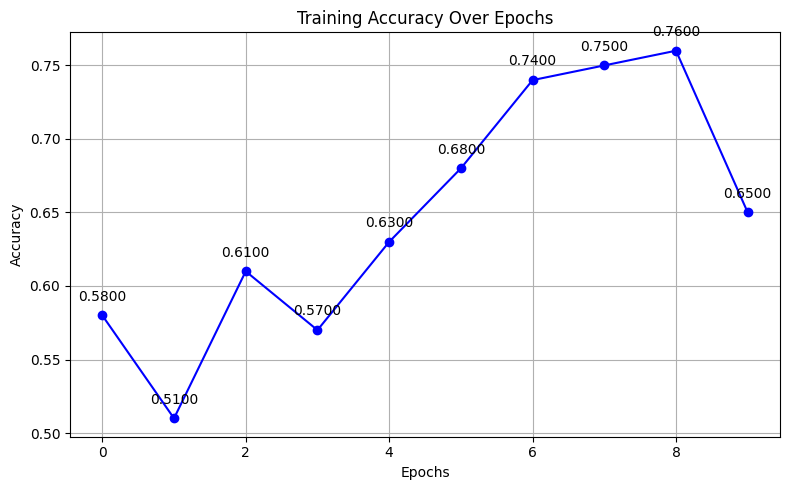

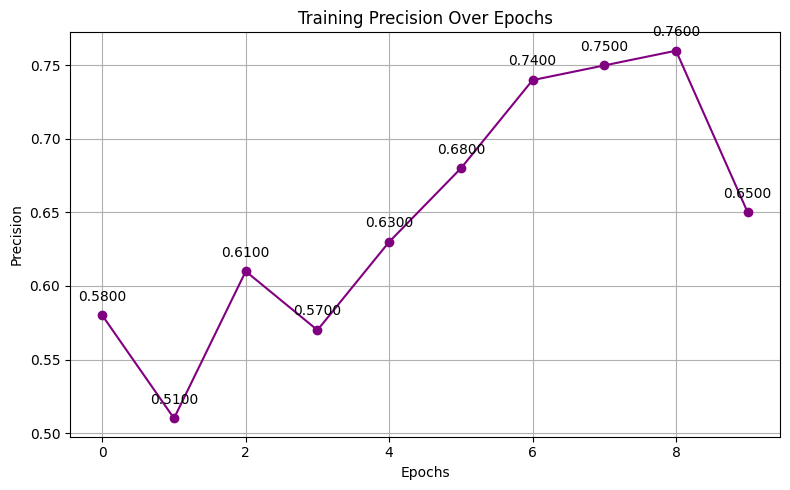

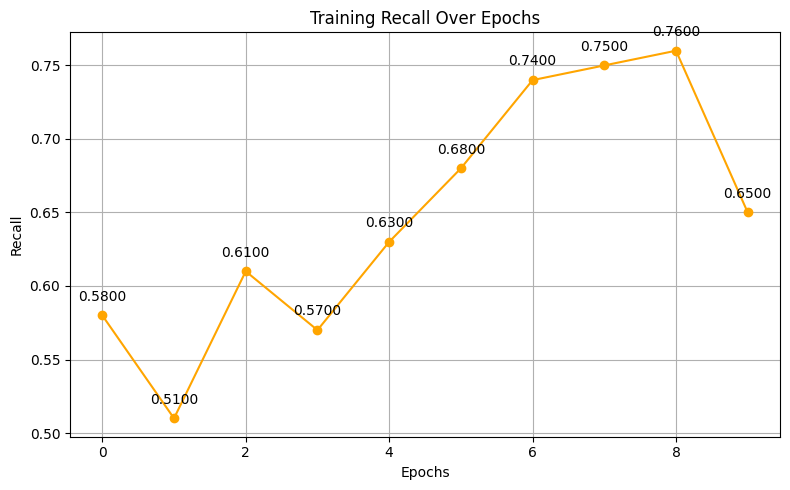

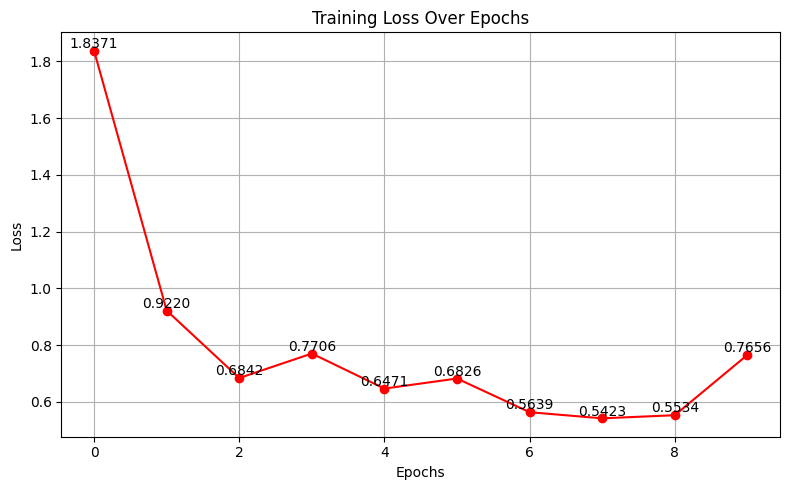

In [ ]:
epochs = range(len(history.history['accuracy']))
train_accuracy = history.history['accuracy']
train_precision = history.history['precision']
train_recall = history.history['recall']
train_loss = history.history['loss']
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
for i, acc in enumerate(train_accuracy):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_accuracy.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_precision, label='Train Precision', color='purple', marker='o')
plt.title('Training Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.grid()
for i, prec in enumerate(train_precision):
    plt.text(i, prec + 0.01, f"{prec:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_precision.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_recall, label='Train Recall', color='orange', marker='o')
plt.title('Training Recall Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.grid()
for i, rec in enumerate(train_recall):
    plt.text(i, rec + 0.01, f"{rec:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_recall.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Train Loss', color='red', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
for i, loss in enumerate(train_loss):
    plt.text(i, loss + 0.01, f"{loss:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_loss.png')
plt.show()

#2

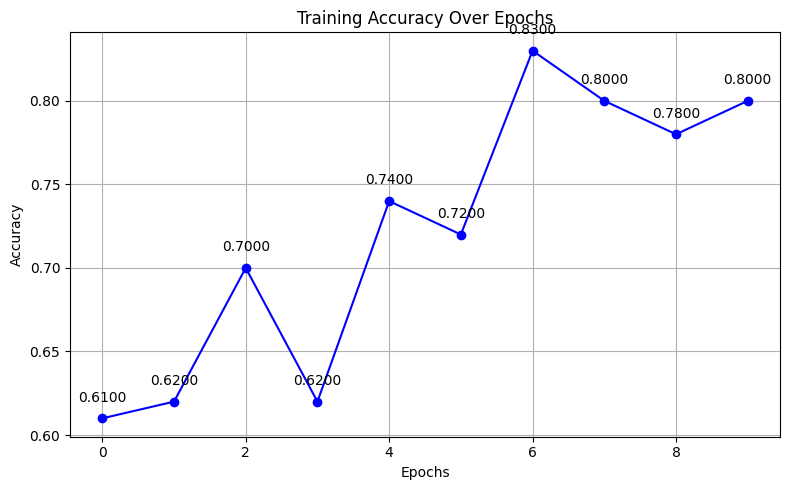

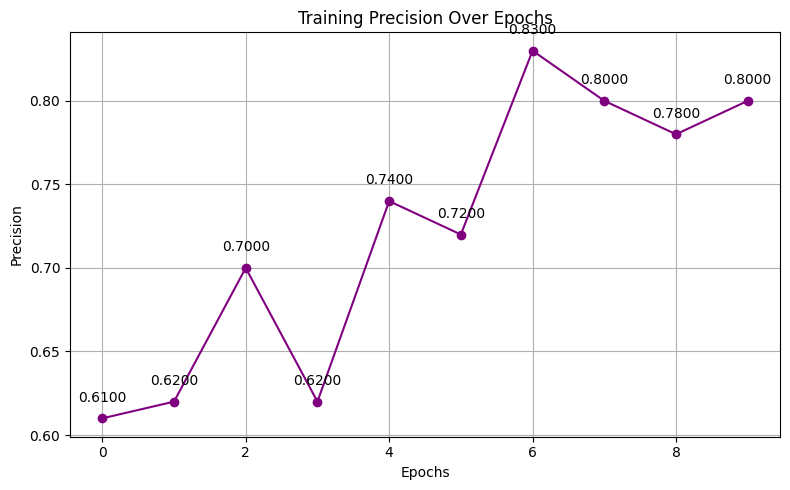

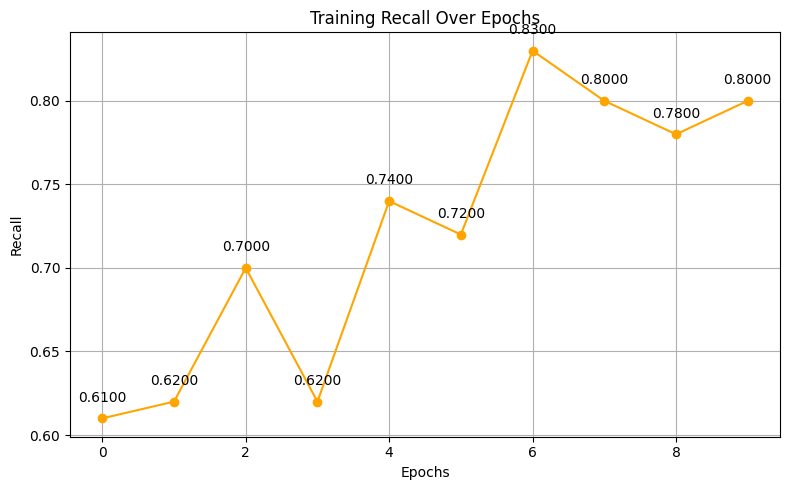

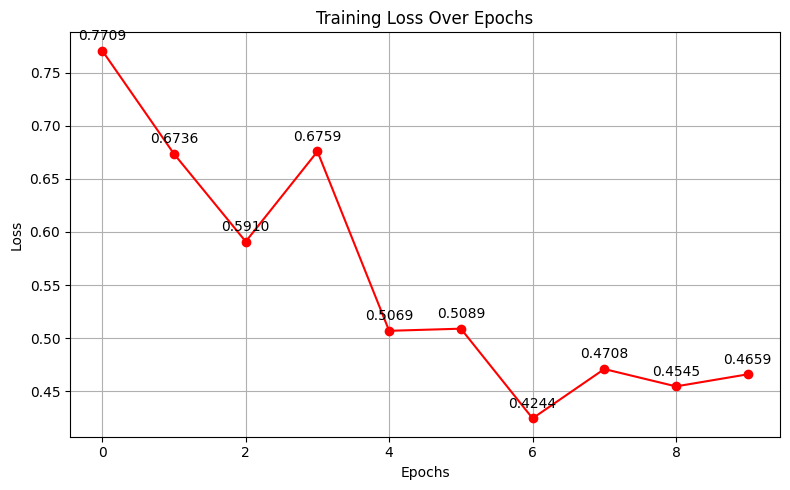

In [ ]:
epochs = range(len(history.history['accuracy']))
train_accuracy = history.history['accuracy']
train_precision = history.history['precision']
train_recall = history.history['recall']
train_loss = history.history['loss']
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_accuracy, label='Train Accuracy', color='blue', marker='o')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
for i, acc in enumerate(train_accuracy):
    plt.text(i, acc + 0.01, f"{acc:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_accuracy.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_precision, label='Train Precision', color='purple', marker='o')
plt.title('Training Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.grid()
for i, prec in enumerate(train_precision):
    plt.text(i, prec + 0.01, f"{prec:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_precision.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_recall, label='Train Recall', color='orange', marker='o')
plt.title('Training Recall Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.grid()
for i, rec in enumerate(train_recall):
    plt.text(i, rec + 0.01, f"{rec:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_recall.png')
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label='Train Loss', color='red', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
for i, loss in enumerate(train_loss):
    plt.text(i, loss + 0.01, f"{loss:.4f}", ha='center')
plt.tight_layout()
plt.savefig('training_loss.png')
plt.show()

###Evaluating Model Performance on 10 Random Test Samples

[0.6945492029190063, 0.5, 0.5, 0.5]


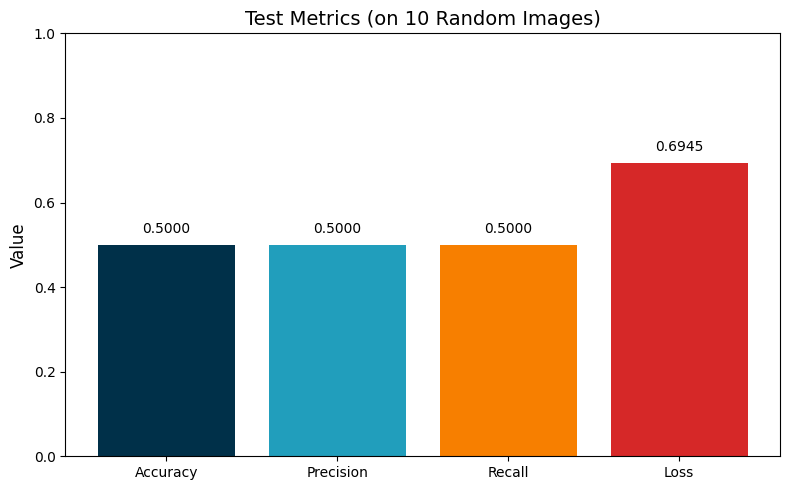

In [ ]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 10)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
test_results = model.evaluate(test_images_tensor, test_labels_tensor, verbose=0)
print(test_results)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]
test_metrics = ['Accuracy', 'Precision', 'Recall', 'Loss']
test_values = [test_accuracy, test_precision, test_recall, test_loss]
plt.figure(figsize=(8, 5))
bars = plt.bar(test_metrics, test_values, color=['#003049', '#219ebc', '#f77f00', '#d62828'])
plt.ylim(0, 1)
plt.title('Test Metrics (on 10 Random Images)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('test_metrics_bar_custom_colors.png')

#2

[0.39569753408432007, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421]


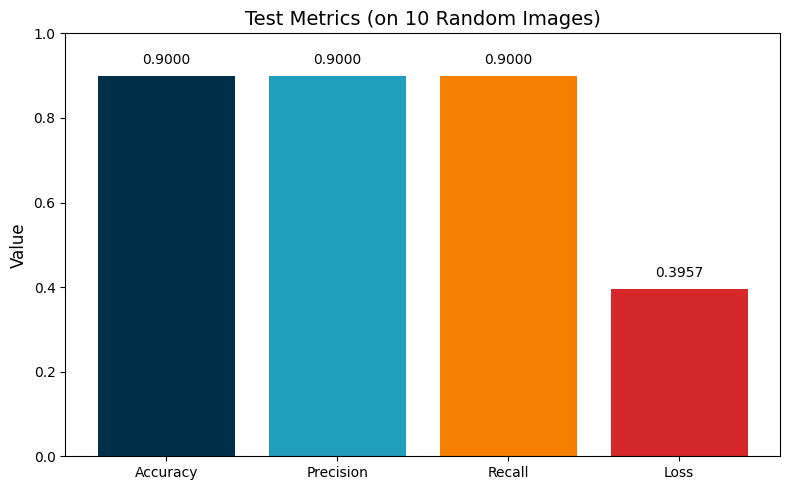

In [ ]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 10)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
test_results = model.evaluate(test_images_tensor, test_labels_tensor, verbose=0)
print(test_results)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]
test_metrics = ['Accuracy', 'Precision', 'Recall', 'Loss']
test_values = [test_accuracy, test_precision, test_recall, test_loss]
plt.figure(figsize=(8, 5))
bars = plt.bar(test_metrics, test_values, color=['#003049', '#219ebc', '#f77f00', '#d62828'])
plt.ylim(0, 1)
plt.title('Test Metrics (on 10 Random Images)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('test_metrics_bar_custom_colors.png')

[0.3937535881996155, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421]


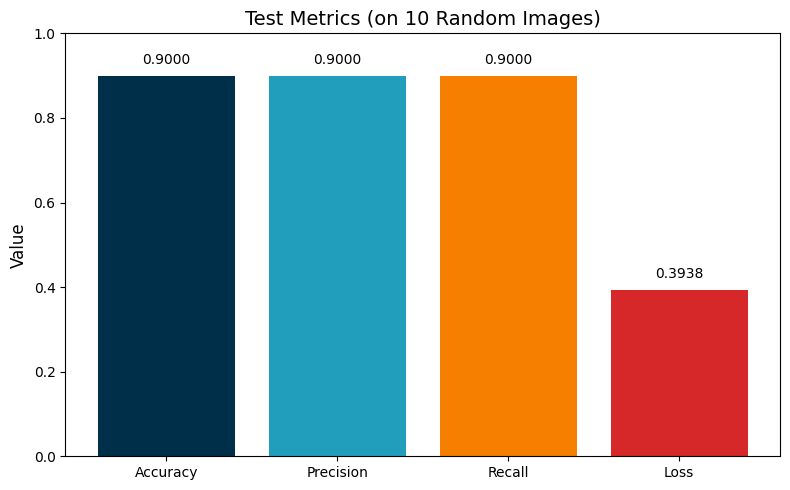

In [ ]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 10)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
test_results = model.evaluate(test_images_tensor, test_labels_tensor, verbose=0)
print(test_results)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]
test_metrics = ['Accuracy', 'Precision', 'Recall', 'Loss']
test_values = [test_accuracy, test_precision, test_recall, test_loss]
plt.figure(figsize=(8, 5))
bars = plt.bar(test_metrics, test_values, color=['#003049', '#219ebc', '#f77f00', '#d62828'])
plt.ylim(0, 1)
plt.title('Test Metrics (on 10 Random Images)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('test_metrics_bar_custom_colors.png')

#third1

[0.4604335427284241, 0.7900000214576721, 0.7900000214576721, 0.7900000214576721]


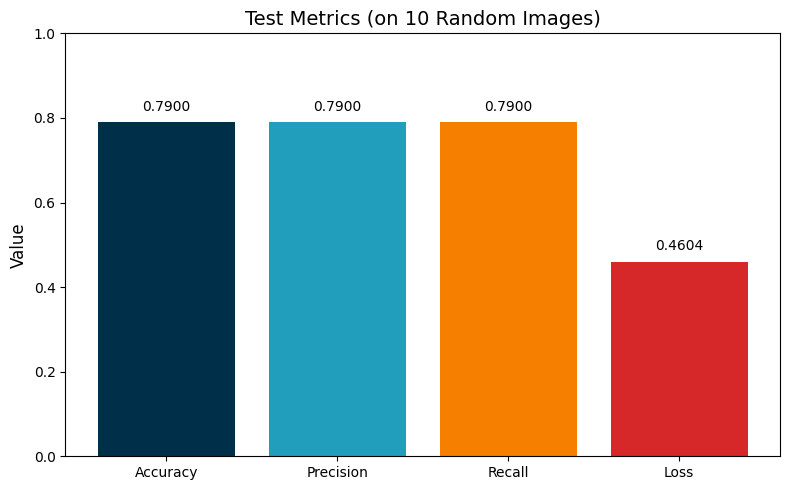

In [ ]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
test_results = model.evaluate(test_images_tensor, test_labels_tensor, verbose=0)
print(test_results)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]
test_metrics = ['Accuracy', 'Precision', 'Recall', 'Loss']
test_values = [test_accuracy, test_precision, test_recall, test_loss]
plt.figure(figsize=(8, 5))
bars = plt.bar(test_metrics, test_values, color=['#003049', '#219ebc', '#f77f00', '#d62828'])
plt.ylim(0, 1)
plt.title('Test Metrics (on 10 Random Images)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('test_metrics_bar_custom_colors.png')

#third2

[0.5255998373031616, 0.8100000023841858, 0.8100000023841858, 0.8100000023841858]


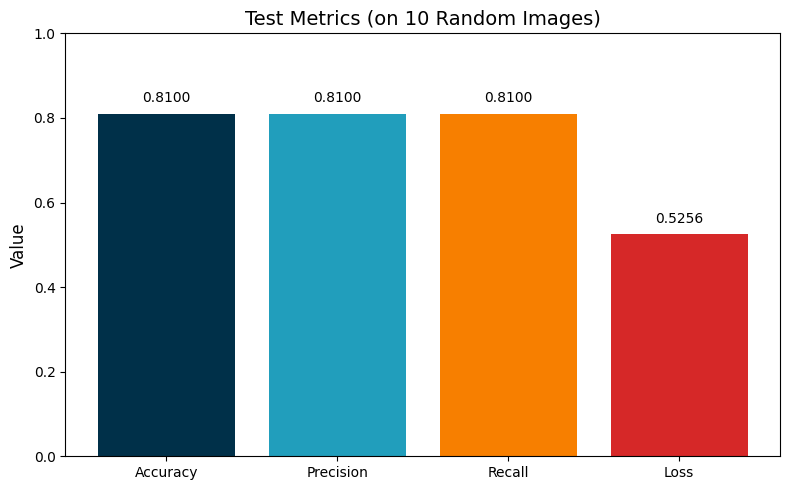

In [ ]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
test_results = model.evaluate(test_images_tensor, test_labels_tensor, verbose=0)
print(test_results)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]
test_metrics = ['Accuracy', 'Precision', 'Recall', 'Loss']
test_values = [test_accuracy, test_precision, test_recall, test_loss]
plt.figure(figsize=(8, 5))
bars = plt.bar(test_metrics, test_values, color=['#003049', '#219ebc', '#f77f00', '#d62828'])
plt.ylim(0, 1)
plt.title('Test Metrics (on 10 Random Images)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('test_metrics_bar_custom_colors.png')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
<ipython-input-81-a0b8741b6e85>:36: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


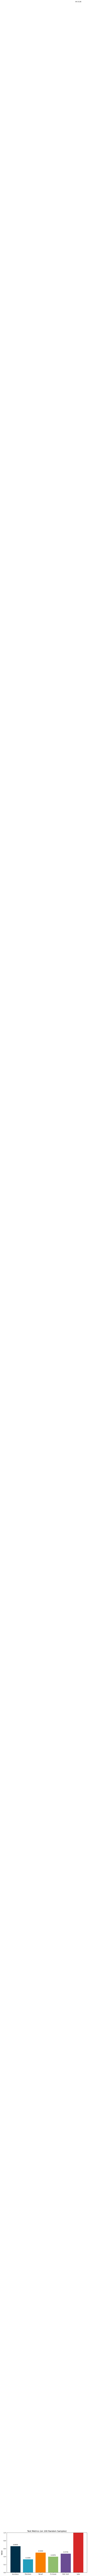

In [ ]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels_tensor.numpy(), axis=1)
test_results = model.evaluate(test_images_tensor, test_labels_tensor, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = precision_score(true_classes, predicted_classes, average='macro')
test_recall = recall_score(true_classes, predicted_classes, average='macro')
test_f1 = f1_score(true_classes, predicted_classes, average='macro')
try:
    test_roc_auc = roc_auc_score(test_labels_tensor.numpy(), predictions, multi_class='ovr')
except ValueError:
    test_roc_auc = 0.0
test_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Loss']
test_values = [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, test_loss]
plt.figure(figsize=(10, 5))
colors = ['#003049', '#219ebc', '#f77f00', '#90be6d', '#6a4c93', '#d62828']
bars = plt.bar(test_metrics, test_values, color=colors)
plt.ylim(0, 1)
plt.title('Test Metrics (on 100 Random Samples)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('test_metrics_bar_custom_classification.png')
plt.show()

#third3

4/4 ━━━━━━━━━━━━━━━━━━━━ 85s 19s/step


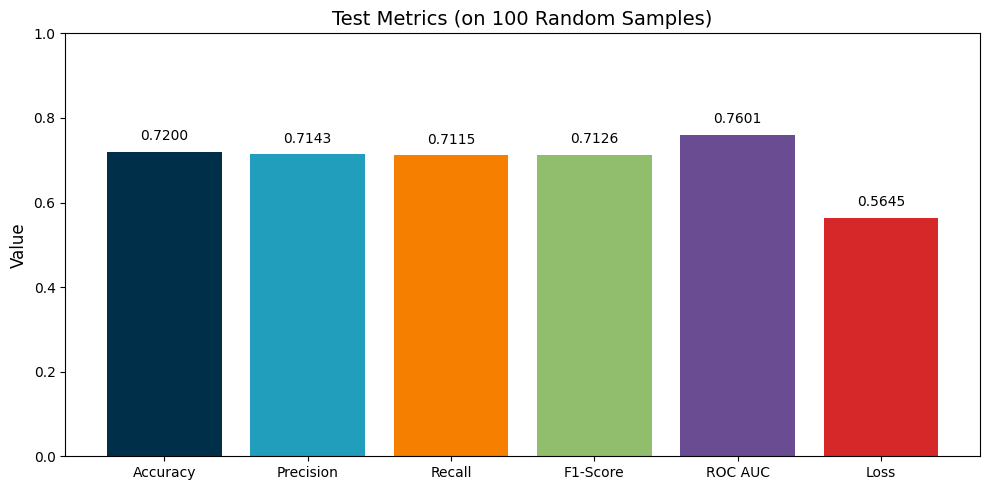

In [ ]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels_tensor.numpy(), axis=1)
test_results = model.evaluate(test_images_tensor, test_labels_tensor, verbose=0)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = precision_score(true_classes, predicted_classes, average='macro')
test_recall = recall_score(true_classes, predicted_classes, average='macro')
test_f1 = f1_score(true_classes, predicted_classes, average='macro')
try:
    test_roc_auc = roc_auc_score(test_labels_tensor.numpy(), predictions, multi_class='ovr')
except ValueError:
    test_roc_auc = 0.0
test_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Loss']
test_values = [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, test_loss]
plt.figure(figsize=(10, 5))
colors = ['#003049', '#219ebc', '#f77f00', '#90be6d', '#6a4c93', '#d62828']
bars = plt.bar(test_metrics, test_values, color=colors)
plt.ylim(0, 1)
plt.title('Test Metrics (on 100 Random Samples)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('test_metrics_bar_custom_classification.png')
plt.show()

###Visualizing Model Predictions Using a Confusion Matrix (10 Random Test Samples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 42s 42s/step


<Figure size 800x600 with 0 Axes>

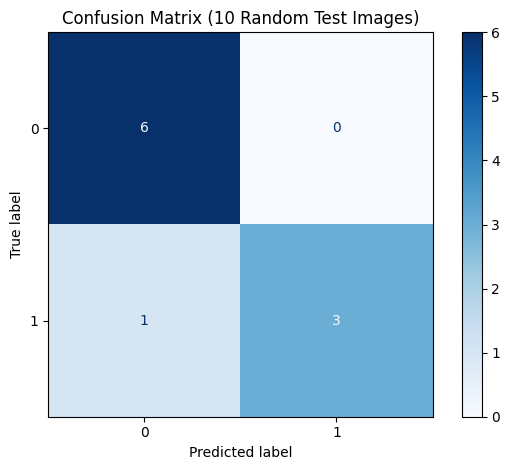

In [ ]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 10)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
y_true = np.argmax(test_labels_tensor.numpy(), axis=1)
y_pred = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (10 Random Test Images)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

#2

1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step


<Figure size 800x600 with 0 Axes>

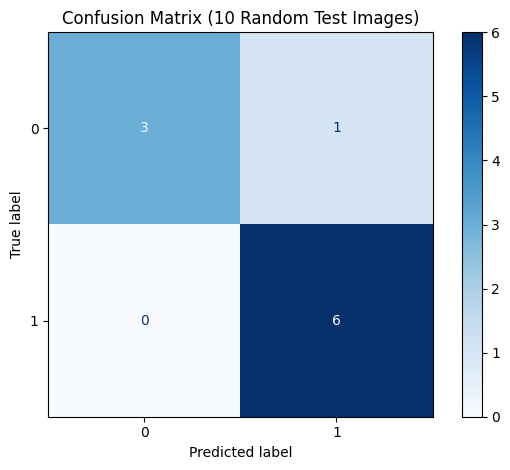

In [ ]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 10)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
y_true = np.argmax(test_labels_tensor.numpy(), axis=1)
y_pred = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (10 Random Test Images)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 87s 19s/step


<Figure size 800x600 with 0 Axes>

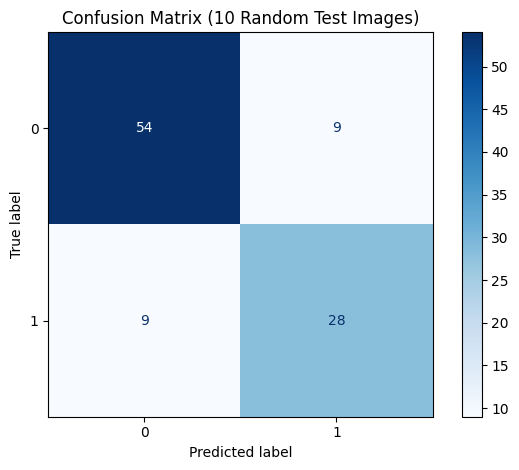

In [ ]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
y_true = np.argmax(test_labels_tensor.numpy(), axis=1)
y_pred = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (10 Random Test Images)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

#first1

4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 18s/step


<Figure size 800x600 with 0 Axes>

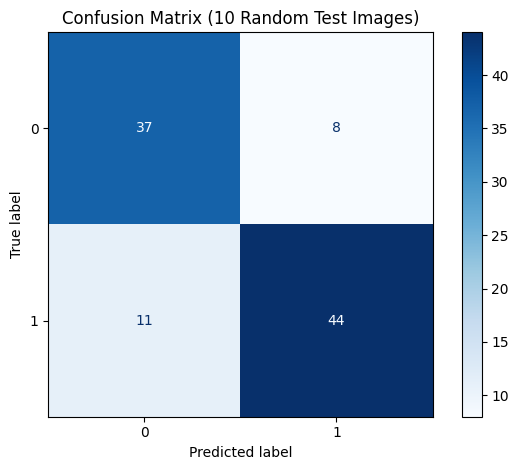

In [ ]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
y_true = np.argmax(test_labels_tensor.numpy(), axis=1)
y_pred = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (10 Random Test Images)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

#third2

4/4 ━━━━━━━━━━━━━━━━━━━━ 103s 21s/step


<Figure size 800x600 with 0 Axes>

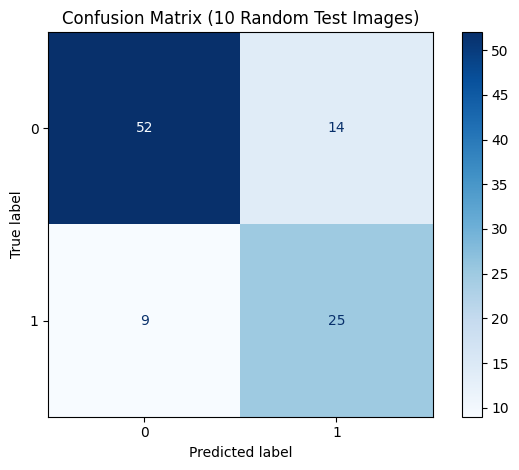

In [ ]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
y_true = np.argmax(test_labels_tensor.numpy(), axis=1)
y_pred = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (10 Random Test Images)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

#third3

4/4 ━━━━━━━━━━━━━━━━━━━━ 67s 15s/step


<Figure size 800x600 with 0 Axes>

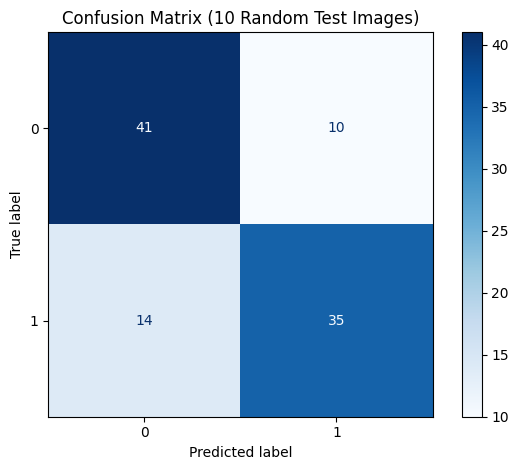

In [ ]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
y_true = np.argmax(test_labels_tensor.numpy(), axis=1)
y_pred = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (100 Random Test Images)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
test_data_list = list(test_dataset.unbatch().take(100))
random_samples = random.sample(test_data_list, 100)
test_images = [sample[0] for sample in random_samples]
test_labels = [sample[1] for sample in random_samples]
test_images_tensor = tf.stack(test_images)
test_labels_tensor = tf.stack(test_labels)
predictions = model.predict(test_images_tensor)
y_true = np.argmax(test_labels_tensor.numpy(), axis=1)
y_pred = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (100 Random Test Images)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

NameError: name 'test_dataset' is not defined

Found 1588 files belonging to 2 classes.
Fold 1/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 6/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 7/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 8/10


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 9/10
Fold 10/10


<ipython-input-71-79151fea6a2d>:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


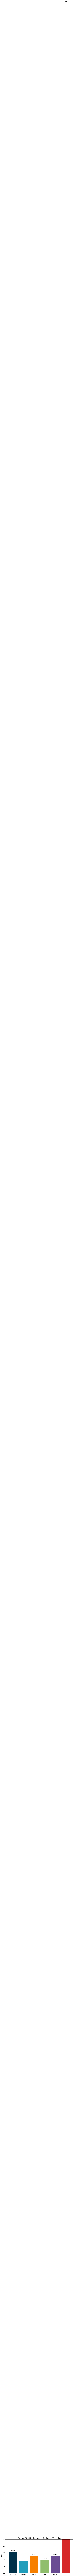

<Figure size 800x600 with 0 Axes>

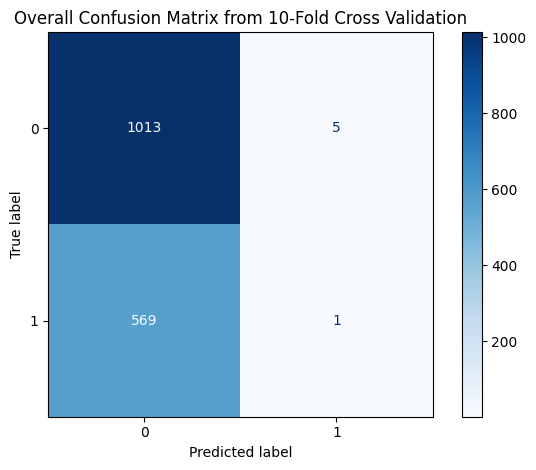

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import gc

# مسیر دیتا
data_dir = '/kaggle/working/merged_images'

# بارگیری کل دیتاست
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    seed=42,
    shuffle=True,
    batch_size=13
)

# باز کردن به صورت لیست برای استفاده در k-fold
all_samples = list(full_dataset.unbatch())
images = [sample[0] for sample in all_samples]
labels = [sample[1] for sample in all_samples]
X = tf.stack(images)
y = tf.stack(labels)

# KFold Cross Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

accuracies, precisions, recalls, f1s, aucs, losses = [], [], [], [], [], []

# برای confusion matrix
all_y_true = []
all_y_pred = []

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'Fold {fold+1}/10')

    X_train, X_test = tf.gather(X, train_index), tf.gather(X, test_index)
    y_train, y_test = tf.gather(y, train_index), tf.gather(y, test_index)

    # ارزیابی با مدل از قبل آموزش‌دیده
    test_results = model.evaluate(X_test, y_test, verbose=0)
    loss = test_results[0]
    accuracy = test_results[1]

    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test.numpy(), axis=1)

    # ذخیره برای confusion matrix کلی
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)

    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    try:
        auc = roc_auc_score(y_test.numpy(), y_pred_probs, multi_class='ovr')
    except ValueError:
        auc = 0.0

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    aucs.append(auc)
    losses.append(loss)

    gc.collect()

# محاسبه میانگین متریک‌ها
avg_metrics = {
    'Accuracy': np.mean(accuracies),
    'Precision': np.mean(precisions),
    'Recall': np.mean(recalls),
    'F1-Score': np.mean(f1s),
    'ROC AUC': np.mean(aucs),
    'Loss': np.mean(losses)
}

# نمودار متریک‌ها
plt.figure(figsize=(10, 5))
colors = ['#003049', '#219ebc', '#f77f00', '#90be6d', '#6a4c93', '#d62828']
bars = plt.bar(avg_metrics.keys(), avg_metrics.values(), color=colors)
plt.ylim(0, 1)
plt.title('Average Test Metrics over 10-Fold Cross Validation', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('average_metrics_10fold.png')
plt.show()

# 🔵 Confusion Matrix کلی پس از 10 فولد
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Overall Confusion Matrix from 10-Fold Cross Validation')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix_10fold.png')
plt.show()


Found 1588 files belonging to 2 classes.
Fold 1/10
Fold 2/10
Fold 3/10
Fold 4/10
Fold 5/10
Fold 6/10
Fold 7/10
Fold 8/10
Fold 9/10
Fold 10/10


<ipython-input-72-4400c591128a>:102: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


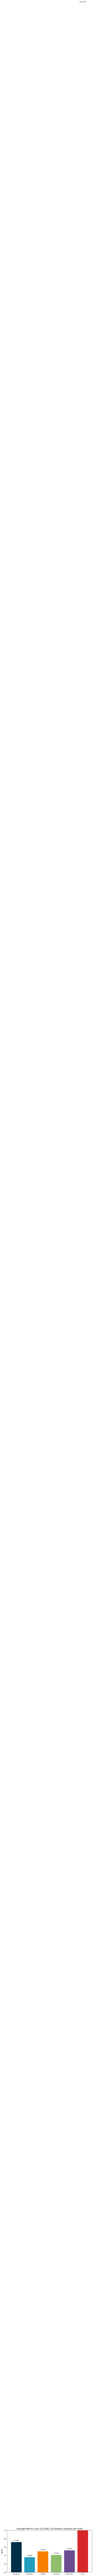

<Figure size 800x600 with 0 Axes>

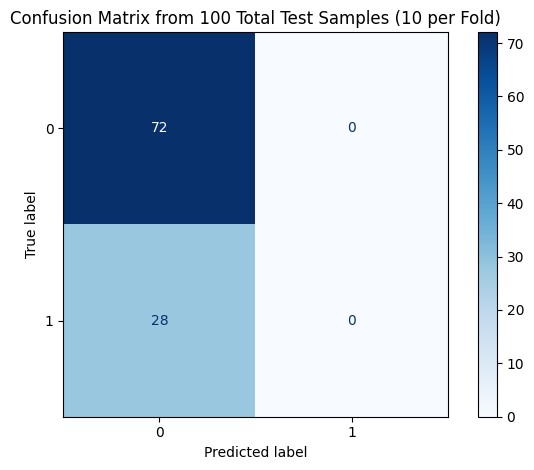

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import gc
import random
data_dir = '/kaggle/working/merged_images'
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(224, 224),
    seed=42,
    shuffle=True,
    batch_size=13
)
all_samples = list(full_dataset.unbatch())
images = [sample[0] for sample in all_samples]
labels = [sample[1] for sample in all_samples]
X = tf.stack(images)
y = tf.stack(labels)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracies, precisions, recalls, f1s, aucs, losses = [], [], [], [], [], []
all_y_true = []
all_y_pred = []
for fold, (train_index, test_index) in enumerate(kf.split(X)):
    print(f'Fold {fold+1}/10')
    X_train, X_test_full = tf.gather(X, train_index), tf.gather(X, test_index)
    y_train, y_test_full = tf.gather(y, train_index), tf.gather(y, test_index)
    total_test_samples = X_test_full.shape[0]
    indices = random.sample(range(total_test_samples), min(10, total_test_samples))
    X_test = tf.gather(X_test_full, indices)
    y_test = tf.gather(y_test_full, indices)
    test_results = model.evaluate(X_test, y_test, verbose=0)
    loss = test_results[0]
    accuracy = test_results[1]
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test.numpy(), axis=1)
    all_y_true.extend(y_true)
    all_y_pred.extend(y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    try:
        auc = roc_auc_score(y_test.numpy(), y_pred_probs, multi_class='ovr')
    except ValueError:
        auc = 0.0
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    aucs.append(auc)
    losses.append(loss)
    gc.collect()
avg_metrics = {
    'Accuracy': np.mean(accuracies),
    'Precision': np.mean(precisions),
    'Recall': np.mean(recalls),
    'F1-Score': np.mean(f1s),
    'ROC AUC': np.mean(aucs),
    'Loss': np.mean(losses)
}
plt.figure(figsize=(10, 5))
colors = ['#003049', '#219ebc', '#f77f00', '#90be6d', '#6a4c93', '#d62828']
bars = plt.bar(avg_metrics.keys(), avg_metrics.values(), color=colors)
plt.ylim(0, 1)
plt.title('Average Metrics over 10 Folds (10 Random Samples per Fold)', fontsize=14)
plt.ylabel('Value', fontsize=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('average_metrics_10fold_limited.png')
plt.show()
conf_matrix = confusion_matrix(all_y_true, all_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix from 100 Total Test Samples (10 per Fold)')
plt.grid(False)
plt.tight_layout()
plt.savefig('confusion_matrix_100samples.png')
plt.show()